In [1]:
%matplotlib inline
import matplotlib as mpl
#mpl.use('Agg')
import numpy as np
import pylab as py
#import Extract_ncfile_save_fluxes_radiation
#import Reload_save_interpolated as svintp
import matplotlib.cm as cm
from reverse_cmap import rcmap
import sys
import os
import errno
import netCDF4 as nc
from mpl_toolkits import mplot3d
# from mayavi import mlab

BuRd = rcmap(cm.RdBu)

import hickle as hkl

#source_dirc=svintp.source
#exp_dirc=["aqua_2m/","aqua_20m/","land_rec20m/"]

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')

## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            raise

# dirc=sys.argv

####################
#### smoothening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

#source='/project2/tas1/pragallva/Fall_quarter_2017/post_process_data/land_realtest/'
source_dir='/project2/tas1/pragallva/Spring_quarter/post_process_data/'
source = source_dir+'aqua_2m/'
            
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

a=6371.0e3
R=a

In [2]:
ncfile='/project2/tas1/pragallva/Spring_quarter_2018/exp_data/aqua_isca5m/aqua_isca5m0.nc'
v_var=nc.Dataset(ncfile,'r')
sigma_full=v_var['pfull'][::-1]
sigma_half=v_var['phalf'][::-1]
lat_nc=v_var['lat']

In [3]:
I1=r'$ ({\Delta D \Delta G)_{a}$'
I2=r'$-(\Delta D) (\Delta G)$'
I3=r'$-(\Delta D) {G_{a}}$'
I4=r'$-{D_{a}} (\Delta G)$'
ISUM=r'$\Delta I =$ '+I1 +I2 +I3 +I4
Iorig=r'$\Delta I =$' + r'$\Delta\langle[\overline{v^{\prime}m^{\prime}}]\rangle$'

I3T=r'$-(\Delta D_T) G_T_{a}$'
I4T=r'$-D_T_{a} (\Delta G_T)$'


I1v=r'$ ({\Delta D \Delta \langle G\rangle)_{a}$'
I2v=r'$-(\Delta D) (\Delta \langle G\rangle)$'
I3v=r'$-(\Delta D) {\langle G\rangle_{a}}$'
I4v=r'$-{D_{a}} (\Delta \langle G\rangle)$'
ISUM=r'$\Delta I =$ '+I1v +I2v +I3v +I4v
Iorig=r'$\Delta I =$' + r'$\Delta\langle[\overline{v^{\prime}m^{\prime}}]\rangle$'

I3vT=r'$-(\Delta D_T) {\langle G_T\rangle_{a}}$'
I4vT=r'$-{D_{T_a}} (\Delta \langle G_T\rangle)$'


In [4]:
import glob
import numpy as np
import scipy.io as sio
import pylab as py
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy import stats

#### Invoke all the files

m5=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la5m_oc5m/*.hkl'))
# m10=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la10m_oc10m/*.hkl'))
m50=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la50m_oc50m/*.hkl'))
#m100=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la100m_oc100m/*.hkl'))

In [5]:
ls /project2/tas1/pragallva/Fall_quarter_2018/post_process_data/data_in_pres_coord/HC0_la5m_oc5m

baroclinicity.hkl  baroclinicity_sfc.hkl  stream_rms.hkl


In [10]:
m5s =(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/data_in_pres_coord/HC0_la5m_oc5m/stream_rms.hkl'))
m50s=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/data_in_pres_coord/HC0_la50m_oc50m/stream_rms.hkl'))

In [11]:
ls /project2/tas1/pragallva/Fall_quarter_2018/post_process_data/data_in_pres_coord/HC0_la5m_oc5m0

ht_temp_sphum.hkl  stream_dic.hkl  stream_rms.hkl  u_v.hkl


In [12]:
uv=(glob.glob('/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/data_in_pres_coord/HC0_la5m_oc5m0/u_v.hkl'))
plevs=load(uv[0])['plevs']

In [13]:
ok= load("/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la5m_oc5m0/zonal_decomposed_fluxes_dic_vert.hkl")
TEsens_5m= ok['TE_sensible']
TEmoist_5m= ok['TE_moist']
TE_5m= ok['TE_flux']

ok= load("/project2/tas1/pragallva/Fall_quarter_2018/post_process_data/HC0_la50m_oc50m0/zonal_decomposed_fluxes_dic_vert.hkl")
TEsens_50m  = ok['TE_sensible']
TEmoist_50m = ok['TE_moist']
TE_50m      = ok['TE_flux']

In [14]:
def spher_div_vert1(x,N=50):
       fac=1#np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
        for p in range(len(sigma_full)):
          for m in range(12):
            div[d,:,p,m]= smooth(np.gradient((x[d,:,p,m])*(fac)/R,dtheta),N)
       return div

In [15]:
# py.contour(lat_nc[:],  -sigma_full, (check_TEsens.mean(axis=0))*2*np.pi*R*np.cos(np.deg2rad(lat_nc))/10**15, cmap=cm.RdBu_r ); py.colorbar()
# py.contourf(lat_nc[:], -sigma_full, (check_TE.mean(axis=0))*2*np.pi*R*np.cos(np.deg2rad(lat_nc))/10**15, cmap=cm.Spectral ); py.colorbar()



In [16]:
# t=0;f=1;r=3;c=5;d=6; fv=4; dv=7; e=2;

DEPTHS=[m5,m50]
DEPTHSs=[m5s,m50s]
flux=[]
flux_vert=[]
div=[]
div_vert=[]
eke=[]
temp=[]
raw=[]

stream_rms=[]

for depth in DEPTHS:
    f=0; e=1; mmcv=2; r=3; fv=4; twm2=5; c=6; d=7; dv=8; mmc=9; tpw=10
    flux.append(load(depth[f]))
    flux_vert.append(load(depth[fv]))
    div.append(load(depth[d])) 
    div_vert.append(load(depth[dv]))
    raw.append(load(depth[r]))
    eke.append(load(depth[e]))
coord=load(m5[c])

for depth in DEPTHSs:
    stream_rms.append(load(depth[0]))


In [17]:
stream_rms[1].keys()

['pot_prime_weighted',
 'pot_prime_unweighted_v',
 'pot_prime_weighted_v',
 'psi_prime_weighted',
 'pot_prime_unweighted',
 'psi_prime_unweighted_v',
 'psi_prime_unweighted',
 'latn',
 'psi_prime_weighted_v']

In [18]:
ncfile='/project2/tas1/pragallva/Spring_quarter_2018/exp_data/aqua_isca5m/aqua_isca5m0.nc'
v_var=nc.Dataset(ncfile,'r')
sigma_full=v_var['pfull'][::-1]
sigma_half=v_var['phalf'][::-1]
lat_nc=v_var['lat']

In [19]:
# m=0
# lat=div[0]['latn']
# ind=np.squeeze(np.where((lat>0) & (lat<90)))
# py.figure(figsize=(10,5))
# for d in range(len(DEPTHS)):
#     py.subplot(2,2,d+1)
#     x=np.squeeze(raw[d]['U'][:,:,:].mean(axis=-1).transpose())
#     py.contourf(lat, (-sigma_full/1000), x,vmin=-60,vmax=60,cmap=cm.seismic); py.colorbar()

In [20]:
def M(X):
    return np.array(X)

In [21]:
def smooth_multi(y, box_pts,smoothing=1,ax=1):
    box = np.ones(box_pts)/box_pts
    y_smooth=np.apply_along_axis(np.convolve, ax, y, box, mode='same')
    if smoothing == 1 :
        return y_smooth
    else :
        return y

In [22]:
lat=div[0]['latn']
def M(X):
    #X=X-X.mean(axis=0)[None,:]
    return X
Iswabs=[]; Ishf=[]; Idhdt=[]; Iolr=[]; Ine=[];
ISW_sfc=[]; ISW_toa=[]; ILW_sfc=[]; Ishflx=[]; Ilhflx=[]; ISFC=[]; ITOA=[]; TS=[]; precip=[]; 
for depth in range(len(DEPTHS)):
    Iswabs.append(M(flux[depth]['SWABS']))
    Ishf.append(M(flux[depth]['SHF']))
    Idhdt.append(M(flux[depth]['dhdt']))
    Iolr.append(M(flux[depth]['olr']))
    ISW_sfc.append(-1*M(flux[depth]['SW_sfc_d'])) ## up
    ILW_sfc.append(M(-1*flux[depth]['LW_sfc_d'])) ## up
    ISW_toa.append(M(flux[depth]['SW_toa_d']))    ## dn
    Ishflx.append(M(flux[depth]['shflx_u']))      ## up
    Ilhflx.append(M(flux[depth]['lhflx_u']))      ## up
    
    ISFC.append(M(flux[depth]['SFC_u']))
    ITOA.append(M(flux[depth]['TOA_d']))
    precip.append(M(flux[depth]['precip']))
    
    Ine.append(Iswabs[depth]+Ishf[depth]-Iolr[depth]-Idhdt[depth])

In [23]:
from scipy import interpolate
def interp(x,xnew, y,ax=1):
    f = interpolate.interp1d(x, y, fill_value='extrapolate', axis=ax)
    ynew = f(xnew)  
    return ynew

TEsens_5m_interp=interp(lat_nc[:],lat, TEsens_5m,ax=-1)
TEsens_50m_interp=interp(lat_nc[:],lat, TEsens_50m,ax=-1)

TEmoist_5m_interp=interp(lat_nc[:],lat, TEmoist_5m,ax=-1)
TEmoist_50m_interp=interp(lat_nc[:],lat, TEmoist_50m,ax=-1)

TE_5m_interp=interp(lat_nc[:],lat, TE_5m,ax=-1)
TE_50m_interp=interp(lat_nc[:],lat, TE_50m,ax=-1)

TEsensv  = 2*np.pi*R*np.cos(np.deg2rad(lat[None,:,None,None]))*(np.append(TEsens_5m_interp[None,...],   TEsens_50m_interp[None,...],  axis=0).transpose((0,3,2,1)))/10**15   
TEmoistv = 2*np.pi*R*np.cos(np.deg2rad(lat[None,:,None,None]))*(np.append(TEmoist_5m_interp[None,...], TEmoist_50m_interp[None,...],  axis=0).transpose((0,3,2,1)))/10**15    
TEtotalv = 2*np.pi*R*np.cos(np.deg2rad(lat[None,:,None,None]))*(np.append(TE_5m_interp[None,...],      TE_50m_interp[None,...],       axis=0).transpose((0,3,2,1)))/10**15



In [24]:
TE=[]; MM=[]; SE=[]; INE=[]; TEv=[]; MMv=[]; SEv=[]; NEv=[]; TE_sens=[]; SE_sens=[]; MM_sens=[]; EKE=[]; EKEv=[]; 
TE_pot=[]; SE_pot=[]; MM_pot=[]; TE_moist=[]; SE_moist=[]; MM_moist=[]
for depth in range(len(DEPTHS)):
    TE.append(M(flux[depth]['TE']))
    TE_sens.append(M(flux[depth]['TE_sens']))
    TE_pot.append(M(flux[depth]['TE_pot']))
    TE_moist.append(M(flux[depth]['TE_moist']))
    SE.append(M(flux[depth]['SE']))
    SE_sens.append(M(flux[depth]['SE_sens']))
    SE_moist.append(M(flux[depth]['SE_moist']))
    SE_pot.append(M(flux[depth]['SE_pot']))
    MM.append(M(flux[depth]['MM']))
    MM_sens.append(M(flux[depth]['MM_sens']))
    MM_pot.append(M(flux[depth]['MM_pot']))
    MM_moist.append(M(flux[depth]['MM_moist']))
    INE.append(TE[depth]+SE[depth]+MM[depth])
    MMv.append(M(flux_vert[depth]['MM']))
    SEv.append(M(flux_vert[depth]['SE']))
    TEv.append(M(flux_vert[depth]['TE']))
    NEv.append(M(flux_vert[depth]['NE'])) 
    EKE.append(M(eke[depth]['EKE_vert']))
    EKEv.append(M(eke[depth]['EKE']))

In [25]:
pot_prime_weighted=[]; pot_prime_unweighted=[]; pot_prime_weighted_v=[]; pot_prime_unweighted_v=[]; 
psi_prime_weighted=[]; psi_prime_unweighted=[]; psi_prime_weighted_v=[]; psi_prime_unweighted_v=[]; 
for depth in range(len(DEPTHSs)):
    pot_prime_weighted.append(M(stream_rms[depth]['pot_prime_weighted']))
    pot_prime_unweighted.append(M(stream_rms[depth]['pot_prime_unweighted']))
    psi_prime_weighted.append(M(stream_rms[depth]['psi_prime_weighted']))
    psi_prime_unweighted.append(M(stream_rms[depth]['psi_prime_unweighted']))
    pot_prime_weighted_v.append(M(stream_rms[depth]['pot_prime_weighted_v']))
    pot_prime_unweighted_v.append(M(stream_rms[depth]['pot_prime_unweighted_v']))
    psi_prime_weighted_v.append(M(stream_rms[depth]['psi_prime_weighted_v']))
    psi_prime_unweighted_v.append(M(stream_rms[depth]['psi_prime_unweighted_v']))


In [26]:
Z=[]; q=[]; U=[]; T=[]; V=[]; MSE=[];
for depth in range(len(DEPTHS)):
    Z.append(M(raw[depth]['Z']))
    q.append(M(raw[depth]['q']))
    U.append(M(raw[depth]['U']))
    T.append(M(raw[depth]['T']))
    MSE.append(M(raw[depth]['MSE']))


In [27]:
T=np.array(T)
sigma_full[1]

921.0435734946946

In [28]:
q=np.array(q); T=np.array(T)
Rd=287.; Rv=461.5; eps=Rd/Rv
def CC(Ts):
    Tcel=Ts-273
    es  = 6.112*np.exp(17.67*Tcel/(Tcel+243.5))
    return es
def Qsat(Ts):
    es=CC(Ts)
    qss = eps*es/(sigma_full[1]-(1-eps)*es)
    return qss

qsat = Qsat(T[...,1,:])
RH= q[...,1,:]/qsat

# save('/project2/tas1/pragallva/climlab/RH.hkl',RH)

In [29]:
# import pylab as py
# py.rc('text', usetex=True)
# py.figure(figsize=(15,10))
# py.subplot(2,2,1)
# py.contourf(range(12),lat,RH[0,...],cmap=cm.seismic); py.colorbar()
# py.subplot(2,2,2)
# py.contourf(range(12),lat,q[0,:,1,:],cmap=cm.seismic); py.colorbar()
# py.subplot(2,2,3)
# py.contourf(range(12),lat,qsat[0,:,:],cmap=cm.seismic); py.colorbar()

In [30]:
div_TE=[]; div_MM=[]; div_SE=[]; div_NE=[]; div_TEv=[]; div_MMv=[]; div_SEv=[]; div_NEv=[]
swabs=[]; shf=[]; olr=[];dhdt=[];ne=[];
SW_sfc=[]; SW_toa=[]; LW_sfc=[]; shflx=[]; lhflx=[]; sfc=[]; toa=[]

for depth in range(len(DEPTHS)):
    div_TE.append(div[depth]['TE'])
    div_SE.append(div[depth]['SE'])
    div_MM.append(div[depth]['MM'])
    div_NE.append(div_TE[depth]+div_SE[depth]+div_MM[depth])
    
    div_TEv.append(div_vert[depth]['TE'])
    div_SEv.append(div_vert[depth]['SE'])
    div_MMv.append(div_vert[depth]['MM'])
    div_NEv.append(div_vert[depth]['NE'])
    
    swabs.append(div[depth]['SWABS'])
    shf.append(div[depth]['SHF'])
    dhdt.append(div[depth]['dhdt'])
    olr.append(div[depth]['olr'])
    ne.append(swabs[depth]+shf[depth]-olr[depth]-dhdt[depth])
    
    SW_sfc.append(-1*div[depth]['SW_sfc_d'])
    LW_sfc.append(-1*div[depth]['LW_sfc_d'])
    SW_toa.append(div[depth]['SW_toa_d'])
    shflx.append(div[depth]['shflx_u'])
    lhflx.append(div[depth]['lhflx_u'])
    sfc.append(div[depth]['SFC_u'])
    toa.append(div[depth]['TOA_d'])
    

# Average Northern and Southern Hemispheres

In [31]:
TE=np.array(TE); SE=np.array(SE); MM=np.array(MM); NE=np.array(INE); 
SE_sens=np.array(SE_sens); MM_sens=np.array(MM_sens);TE_sens=np.array(TE_sens)
SE_pot=np.array(SE_pot); MM_pot=np.array(MM_pot); TE_pot=np.array(TE_pot);
SE_moist=np.array(SE_moist); MM_moist=np.array(MM_moist); TE_moist=np.array(TE_moist);
TEv=np.array(TEv); SEv=np.array(SEv); MMv=np.array(MMv); NEv=np.array(NEv)
div_TEv=np.array(div_TEv); div_SEv=np.array(div_SEv); div_MMv=np.array(div_MMv); div_NEv=np.array(div_NEv)

Iswabs=np.array(Iswabs); Ishf=np.array(Ishf); Ine=np.array(Ine); Iolr=np.array(Iolr); Idhdt=np.array(Idhdt);
ISW_sfc=np.array(ISW_sfc); ILW_sfc=np.array(ILW_sfc); ISW_toa=np.array(ISW_toa); Ishflx=np.array(Ishflx); Ilhflx=np.array(Ilhflx);

ISFC=np.array(ISFC); ITOA=np.array(ITOA)
Z=np.array(Z); q=np.array(q); U=np.array(U); T=np.array(T); V=np.array(V); MSE=np.array(MSE);
EKEv=np.array(EKEv); EKE=np.array(EKE); 

pot_prime_weighted=np.array(pot_prime_weighted); psi_prime_weighted=np.array(psi_prime_weighted)
pot_prime_unweighted=np.array(pot_prime_unweighted); psi_prime_unweighted=np.array(psi_prime_unweighted)
pot_prime_unweighted_v=np.array(pot_prime_unweighted_v); psi_prime_unweighted_v=np.array(psi_prime_unweighted_v)
pot_prime_weighted_v=np.array(pot_prime_weighted_v); psi_prime_weighted_v=np.array(psi_prime_weighted_v)

stream_int = psi_prime_weighted
stream_850 =psi_prime_weighted_v[:,:,-4,...]


In [32]:
stream_850.shape

(2, 1741, 12)

In [33]:
# d=0
# py.figure(figsize=(16,3))
# py.subplot(1,4,3)
# py.contourf(range(12), lat, psi_prime_weighted[d,...], cmap=cm.Blues); py.colorbar()
# py.contour(range(12), lat, TE[d,...],colors='k'); 
# py.subplot(1,4,4)
# py.contourf(range(12), lat, psi_prime_unweighted[d,...], cmap=cm.Blues); py.colorbar()
# py.contour(range(12), lat, TE[d,...],colors='k'); 


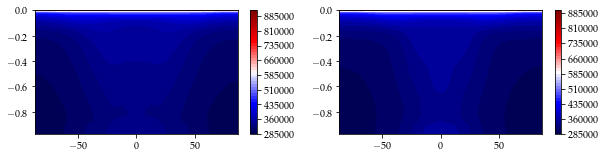

In [34]:
Cp=1000; L=2260*1000; g=10
field=Cp*T+g*Z+L*q
m=0
lat=div[0]['latn']
ind=np.squeeze(np.where((lat>0) & (lat<90)))
py.figure(figsize=(10,5))
for d in range(len(DEPTHS)):
    py.subplot(2,2,d+1)
    x=np.squeeze(field[d,:,:,:].mean(axis=-1).transpose())
    py.contourf(lat,(-sigma_full/1000), x, 50,cmap=cm.seismic); py.colorbar()

In [35]:
def N_S_avg(TE, SE, MM, NE, temp, lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))
    
    avg = lambda x: (x[:,l_N,...]+flux_flag*np.roll(x[:,l_S,...][:,::-1,...], 6, axis=-1))/2.0
    
    TE1= avg(TE)
    SE1= avg(SE)
    NE1= avg(NE)
    MM1= avg(MM)
    
    temp= avg(temp)
    
    a= lambda x: np.append(x,x[...,0,None],axis=-1)
    
    return a(TE1), a(SE1), a(MM1), a(NE1), a(temp), lat[l_N]

In [36]:
TE_a   ,SE_a     , MM_a   , NE_a     ,ignore,  lat_a = N_S_avg(TE, SE, MM, NE,NE, lat)
TEv_a  ,SEv_a    , MMv_a  , NEv_a    ,ignore,  lat_a = N_S_avg(TEv, SEv, MMv, NEv,NEv, lat)
TEpot_a   ,SEpot_a  , MMpot_a   , NE_a     ,ignore,  lat_a = N_S_avg(TE_pot, SE_pot, MM_pot, NE,NE, lat)
Iswabs_a,Ishf_a  , Ine_a , Iolr_a, Idhdt_a, latr_a = N_S_avg( Iswabs,Ishf,Ine,Iolr,Idhdt, lat[1:-1] )
ISW_sfc_a, ILW_sfc_a  , ISW_toa_a , Ishflx_a, Ilhflx_a, latr_a = N_S_avg( ISW_sfc,ILW_sfc,ISW_toa, Ishflx, Ilhflx, lat[1:-1] )
ISFC_a = N_S_avg( ISFC,ISFC,ISFC,ISFC,ISFC, lat[1:-1] )[0]
ITOA_a = N_S_avg( ITOA,ITOA,ITOA,ITOA,ITOA, lat[1:-1] )[0]

CpTv_a  ,gZv_a, Lqv_a, stream_850_a, stream_int_a,  lat_a = N_S_avg(Cp*T, g*Z, L*q, stream_850,stream_int, lat, 1)

EKE_a, EKEv_a = N_S_avg(EKE, EKEv, EKEv, EKEv,EKEv, lat, 1)[0:2]



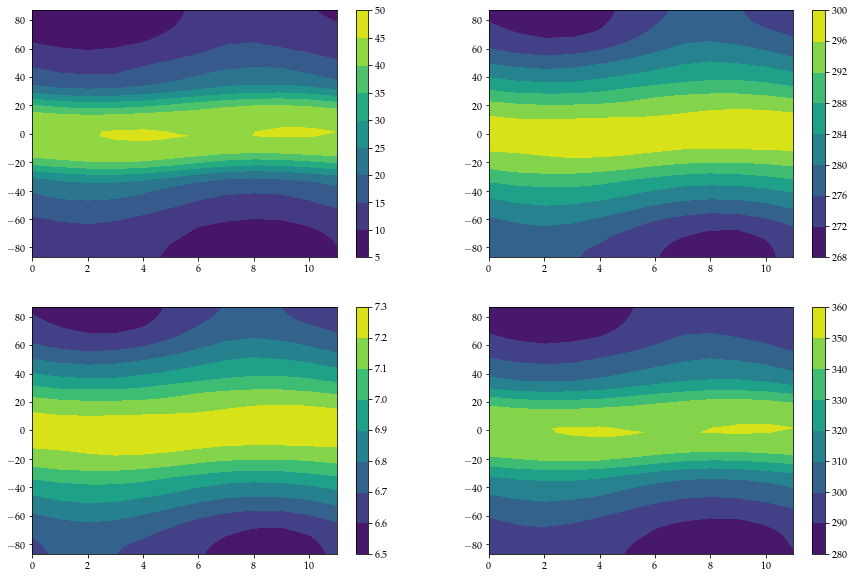

In [37]:
py.figure(figsize=(15,10))
py.subplot(2,2,1)
py.contourf(range(12),lat, L*q[1,:,1,:]/Cp); py.colorbar()
py.subplot(2,2,2)
py.contourf(range(12),lat, Cp*T[1,:,1,:]/Cp); py.colorbar()
py.subplot(2,2,3)
py.contourf(range(12),lat, g*Z[1,:,1,:]/Cp); py.colorbar()
py.subplot(2,2,4)
py.contourf(range(12),lat, (Cp*T+L*q+g*Z)[1,:,1,:]/Cp); py.colorbar()

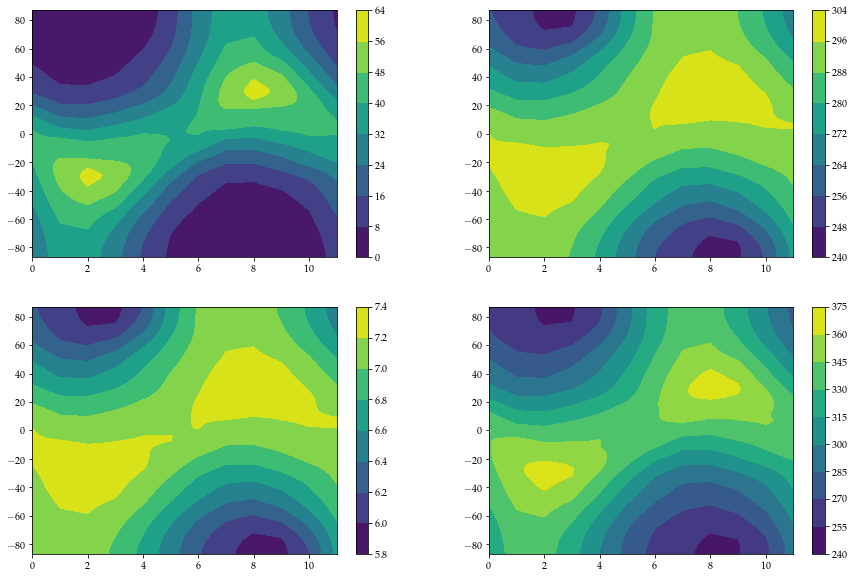

In [38]:
py.figure(figsize=(15,10))
py.subplot(2,2,1)
py.contourf(range(12),lat, L*q[0,:,1,:]/Cp); py.colorbar()
py.subplot(2,2,2)
py.contourf(range(12),lat, Cp*T[0,:,1,:]/Cp); py.colorbar()
py.subplot(2,2,3)
py.contourf(range(12),lat, g*Z[0,:,1,:]/Cp); py.colorbar()
py.subplot(2,2,4)
py.contourf(range(12),lat, (Cp*T+L*q+g*Z)[0,:,1,:]/Cp); py.colorbar()

In [39]:
# save('/project2/tas1/pragallva/climlab/Lq.hkl',L*q)

In [40]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div(x, lat1=lat_a):
       N=50
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
        for m in range(13):
           div[d,:,m]= smooth( np.gradient((x[d,:,m])*(fac),dtheta)/( 2*np.pi*R**2*np.cos(np.radians(lat1[:])) ),N)
       return div


div_TE_a=spher_div(TE_a*10**15)
div_SE_a=spher_div(SE_a*10**15)
div_MM_a=spher_div(MM_a*10**15)
div_NE_a=div_TE_a+div_SE_a+div_MM_a

# div_TEv_a, div_SEv_a, div_MMv_a, div_NEv_a,ignore,lat_a = N_S_avg(div_TEv, div_SEv, div_MMv, div_NEv,div_NEv, lat,flux_flag=1)

In [41]:
lat=div[0]['latn']

from scipy.interpolate import interp1d

def find_zero(div):
  zero_loc = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
      for m in range(0,13):
            l_range=((lat_a>=30) & (lat_a<=60))            
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(0)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

storm_pos=find_zero(div_TE_a)

In [42]:
dtheta=np.radians(lat_a[1]-lat_a[0])

def spher_div_vert(x):
       N=50
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
        for p in range(len(sigma_full)):
          for m in range(13):
            div[d,:,p,m]= smooth(np.gradient((x[d,:,p,m])*(fac)/R,dtheta),N)
       return div

div_CpT=spher_div_vert(CpTv_a)
div_gZ=spher_div_vert(gZv_a)
div_Lq=spher_div_vert(Lqv_a)
MSEv_a=CpTv_a+gZv_a+Lqv_a
div_MSE=spher_div_vert(MSEv_a)

# div_TEv_a, div_SEv_a, div_MMv_a, div_NEv_a,ignore,lat_a = N_S_avg(div_TEv, div_SEv, div_MMv, div_NEv,div_NEv, lat,flux_flag=1)

In [43]:
def spher_div_vert(x):
       N=50
       fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
        for p in range(len(sigma_full)):
          for m in range(13):
            div[d,:,p,m]= smooth(np.gradient((x[d,:,p,m])*(fac)/R,dtheta),N)
       return div

In [44]:
# Cp=1000; L=2260*1000; g=10
# field=div_CpT
# m=m+1
# lat=div[0]['latn']
# ind=np.squeeze(np.where((lat>0) & (lat<90)))
# py.figure(figsize=(10,5))
# for d in range(len(DEPTHS)):
#     py.subplot(2,2,d+1)
#     x=np.squeeze(field[d,:,:,m].transpose())
#     py.contourf(lat_a,(-sigma_full/1000), x, 50,cmap=cm.seismic); py.colorbar()

In [45]:
# d=0
# py.figure(figsize=(15,6))
# field=MSEv_a
# v=np.linspace(np.min(field), 430000,30)
# for m in range(12):
#     py.subplot(3,4,m+1)
#     py.contourf(lat_a,sigma_full, (field[d,...,m]).transpose(),v,cmap=cm.seismic);py.colorbar()
#     c=py.contour(lat_a,sigma_full, (TEv_a[d,...,m]).transpose(),colors='k')#; py.colorbar()
#     py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=10)
#     py.gca().invert_yaxis()
# #     py.xlim(20,70)
# py.tight_layout()

In [46]:
import numpy.ma as ma

threshold=0.001
mask_of_TE      = ma.masked_greater_equal(TEv_a, threshold)  ### Positive transient eddies
mask_of_div_MSE = ma.masked_less_equal(div_MSE, -1*threshold) ### Negative MSE gradient
mask_of_div_CpT = ma.masked_less_equal(div_CpT, -1*threshold) ### Negative MSE gradient

not_mask_of_TE      = ma.masked_less(TEv_a, threshold)  ### Positive transient eddies
not_mask_of_div_MSE = ma.masked_greater(div_MSE, -1*threshold) ### Negative MSE gradient
masked_div_MSE = ma.masked_where( ma.getmask(not_mask_of_div_MSE) , div_MSE)

not_mask_of_div_CpT = ma.masked_greater(div_CpT, -1*threshold) ### Negative MSE gradient
masked_div_CpT      = ma.masked_where( ma.getmask(not_mask_of_div_CpT) , div_CpT)

masked_TE           = ma.masked_where( ma.getmask(not_mask_of_TE), TEv_a)


### Masked div MSE  - all pressure levels

In [47]:
# d=0
# py.figure(figsize=(15,6))
# field=masked_div_MSE
# v=np.linspace(np.nanmin(field),0,10)
# for m in range(12):
#     py.subplot(3,4,m+1)
#     py.contourf(lat_a,sigma_full, (field[d,...,m]).transpose(),v, cmap=rcmap(cm.Blues));py.colorbar()
#     c=py.contour(lat_a,sigma_full, (masked_TE[d,...,m]).transpose(),colors='k')#; py.colorbar()
#     py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=10)
#     py.gca().invert_yaxis()
# #     py.xlim(20,70)
# py.suptitle("div MSE",fontsize=20,y=1.05)
# py.tight_layout()
# py.show()

### Masked TE  - all pressure levels

In [48]:
# d=0
# py.figure(figsize=(15,6))
# field=masked_TE
# v=np.linspace(0,np.nanmax(field),30)
# for m in range(12):
#     py.subplot(3,4,m+1)
#     py.contourf(lat_a,sigma_full, (field[d,...,m]).transpose(),v, cmap=(cm.Reds));py.colorbar()
#     c=py.contour(lat_a,sigma_full, (masked_TE[d,...,m]).transpose(),colors='k')#; py.colorbar()
#     py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=10)
#     py.gca().invert_yaxis()
# #     py.xlim(20,70)
# py.suptitle("TE",fontsize=20,y=1.05)
# py.tight_layout()
# py.show()

### Masked diffusivity - all pressure levels

In [49]:
# diffusivity= -1*(masked_TE/masked_div_MSE)

# d=0
# py.figure(figsize=(15,6))
# field=diffusivity
# v=np.linspace(0,90,10)
# for m in range(12):
#     py.subplot(3,4,m+1)
#     py.contourf(lat_a,sigma_full, (field[d,...,m]).transpose(),v, cmap=(cm.Purples));py.colorbar()
#     c=py.contour(lat_a,sigma_full, (masked_TE[d,...,m]).transpose(),colors='k')#; py.colorbar()
#     py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=20, fontsize=10)
#     py.gca().invert_yaxis()
# #     py.xlim(20,70)
# py.suptitle("Diffusivity",fontsize=20,y=1.05)
# py.tight_layout()
# py.show()

### My definition of diffusivity - all pressure levels

In [50]:
# def mean(X):
# #     return X[...,:-1].mean(axis=-1)[...,None]
#       return (np.asarray( [X[...,:-1].mean(axis=-1)]*13).transpose(1,2,3,0))
# def prime(X):
#     return X-mean(X)

# D_mean =mean(diffusivity)
# Im_mean=mean(masked_div_MSE)
# I_mean =mean(masked_TE)

# D_prime =prime(diffusivity)
# Im_prime=prime(masked_div_MSE)
# I_prime =prime(masked_TE)

## $I^{\prime}=\overline{D^{\prime}I_{m}^{\prime}}-D^{\prime}I_{m}^{\prime}-D^{\prime}\overline{I_{m}}-\overline{D}I_{m}^{\prime}$

In [51]:
# i1= mean(D_prime*Im_prime)
# i2= -1*D_prime*Im_prime
# i3= -1*D_prime*Im_mean
# i4= -1*D_mean*Im_prime

In [52]:
def plot_vert_months(field,d,title):
    py.figure(figsize=(15,6))
    v=np.arange(-0.50,0.501,0.001)
    for m in range(12):
        py.subplot(3,4,m+1)
        py.contourf(lat_a,sigma_full, (field[d,...,m]).transpose(),v, cmap=(cm.seismic));py.colorbar()
        c=py.contour(lat_a,sigma_full, (prime(masked_TE)[d,...,m]).transpose(),colors='k')#; py.colorbar()
        py.clabel(c,  inline=1,fmt = '%1.1f',inline_spacing=12, fontsize=10)
        py.gca().invert_yaxis()
    #     py.xlim(20,70)
    py.suptitle(title,fontsize=20,y=1.05)
    py.tight_layout()
    py.show()

In [53]:
# plot_vert_months(i1,0,r'$\overline{D^{\prime}I_{m}^{\prime}}$')

In [54]:
# plot_vert_months(i2,0,r'$-D^{\prime}I_{m}^{\prime}$')

In [55]:
# plot_vert_months(i3,0,r'$-D^{\prime}\overline{I_{m}}$')

In [56]:
# plot_vert_months(i4,0,r'$-\overline{D}I_{m}^{\prime}$')

In [57]:
# plot_vert_months(i1+i2+i3+i4,0,r'$I^{\prime}$')

In [58]:
# pick the storm track position and identify the index
from scipy.interpolate import interp1d
def inerp_at_max(flux,lat, pos=storm_pos):
  D = np.zeros((len(DEPTHS),13))
  for d in range(0,len(DEPTHS)):
    for m in range(0,13):
        l_range=((lat>=30) & (lat<=60)) 
        X=pos
        interpolation_function = interp1d(lat[l_range],flux[d,l_range,m],kind='cubic')
        try :
            D[d,m]=interpolation_function(X[d,m])
        except ValueError as err:
            D[d,m]==np.nan        
  return D

Intensity_te=inerp_at_max(TE_a,lat_a)
Intensity_se=inerp_at_max(SE_a,lat_a)
Intensity_mm=inerp_at_max(MM_a,lat_a)
Intensity_ne=inerp_at_max(NE_a,lat_a)


### Interp i1 i2 at storm track position

In [59]:
# i1_a=inerp_at_max(i1_sum,lat_a)
# i2_a=inerp_at_max(i2_sum,lat_a)
# i3_a=inerp_at_max(i3_sum,lat_a)
# i4_a=inerp_at_max(i4_sum,lat_a)

# i_a       =inerp_at_max(i_sum,lat_a)
# teprime_a =inerp_at_max(TE_prime,lat_a)

In [60]:
def plot_at_storm_position(d,l,month_to_month=1,f='T'):
    
    DEPTHS_title=["5m","50m"]     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
#     def D(y,d):
#         return y[d,...]
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        
    if f=='T':
            py.plot(D(i3_a,d),'ko-',label=I3T,lw=3.5)
            py.plot(D(i4_a,d),'bo-',label=I4T,lw=3.5)
    else :
            py.plot(D(i3_a,d),'ko-',label=I3,lw=3.5)
            py.plot(D(i4_a,d),'bo-',label=I4,lw=3.5)

      
    py.plot(D(Intensity_te,d),'ro-',label=r'$\Delta I$',lw=3.5) 
                                             
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title=""+" "+" "+str(depth)+"m"
    py.title(str(DEPTHS_title[d]),fontsize=35,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.legend(loc='best',fontsize=20,ncol=2,frameon=False)
    py.tight_layout()

## Plot my definition of Diffusivity decomposition

In [61]:
# l=6.0; i=0;
# fig=py.figure(figsize=(38, 12))
# for d in range(len(DEPTHS)):
#     py.subplot(2,4,i+1)
#     plot_at_storm_position(d,l,0)
#     i=i+1
#     py.tight_layout()

## Plot my definition of Diffusivity decomposition

In [62]:
# d=0
# py.figure(figsize=(15,10))
# r=3; c=2; n=0
# v=np.arange(-7.5,7.75, 0.25); n=n+1
# py.subplot(r,c,n); py.title(Iorig,fontsize=20)
# py.contourf(range(13),lat_a,TE_prime[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n); py.title(ISUM,fontsize=20)
# py.contourf(range(13),lat_a,i_sum[d,...],v, cmap=cm.seismic);py.colorbar(); n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I1,fontsize=20)
# py.contourf(range(13),lat_a,i1_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I2,fontsize=20)
# py.contourf(range(13),lat_a,i2_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I3,fontsize=20)
# py.contourf(range(13),lat_a,i3_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I4,fontsize=20)
# py.contourf(range(13),lat_a,i4_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])
# py.tight_layout()

In [63]:
# d=1
# py.figure(figsize=(15,10))
# r=3; c=2; n=0
# v=np.arange(-4.0,4.25, 0.25); n=n+1
# py.subplot(r,c,n); py.title(Iorig,fontsize=20)
# py.contourf(range(13),lat_a,TE_prime[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n); py.title(ISUM,fontsize=20)
# py.contourf(range(13),lat_a,i_sum[d,...],v, cmap=cm.seismic);py.colorbar(); n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I1,fontsize=20)
# py.contourf(range(13),lat_a,i1_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I2,fontsize=20)
# py.contourf(range(13),lat_a,i2_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I3,fontsize=20)
# py.contourf(range(13),lat_a,i3_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.subplot(r,c,n);      py.title(I4,fontsize=20)
# py.contourf(range(13),lat_a,i4_sum[d,...],v, cmap=cm.seismic);py.colorbar();n=n+1
# py.plot(range(13),storm_pos[d,:])

# py.tight_layout()

## Diffusivity at the surface 

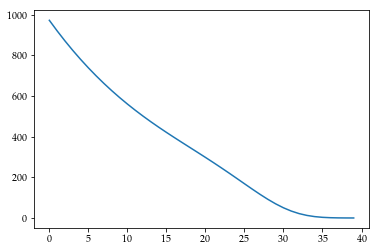

In [64]:
py.rc('text', usetex=True)
py.plot(sigma_full)

## Saving diffusivity for climlab for transient eddies

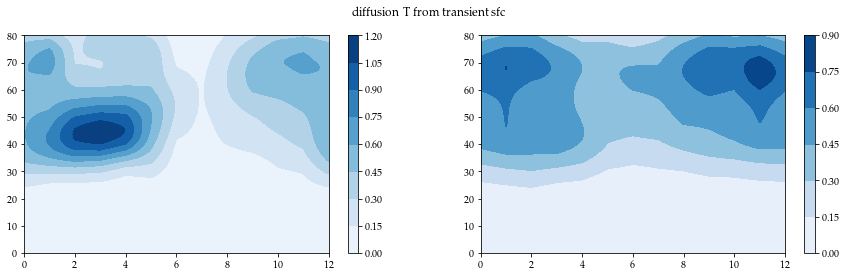

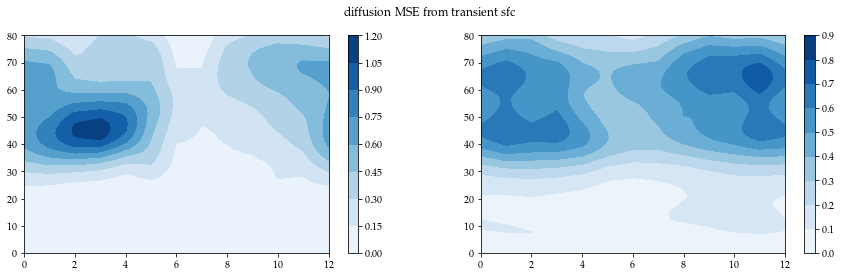

In [65]:
import numpy.ma as ma

level=1

def add_month(y):
    return np.append(y,y[...,0,None],axis=-1)

def save_from_zero_error(threshold,y):
    ind=(np.where((y<threshold) & (y>0)))
    y[ind]=threshold
    ind=(np.where((y>-1*threshold) & (y<0)))
    y[ind]=-1*threshold
    return y

def remove_negative(threshold,y):
    ind=(np.where((y<threshold)))
    y[ind]=threshold
    return y

def smooth_multi(y, box_pts,smoothing=1,ax=1):
    box = np.ones(box_pts)/box_pts
    y_smooth=np.apply_along_axis(np.convolve, ax, y, box, mode='same')
    if smoothing == 1 :
        return y_smooth
    else :
        return y

Tv=add_month(T)
divT= spher_div_vert(Tv)
divMSE_all = spher_div_vert(add_month(Cp*T+g*Z+L*q))

import numpy.ma as ma

threshold               = 0.0001

dm_by_dphi              = divMSE_all[...,level,:]
dm_by_dphi              = save_from_zero_error(0.004,dm_by_dphi)
dT_by_dphi              = divT[...,level,:]
dT_by_dphi              = save_from_zero_error(0.000002,dT_by_dphi)

diffus_sfc_mse          = -add_month(TE)*10**15/(2*np.pi*a**3*np.cos(np.deg2rad(lat[None,:,None]))*dm_by_dphi)
diffus_sfc_mse          = remove_negative(0.00001,smooth_multi(diffus_sfc_mse,100))
diffus_sfc_T            = -add_month(TE_sens)*10**15/(2*np.pi*a**3*np.cos(np.deg2rad(lat[None,:,None]))*dT_by_dphi)
diffus_sfc_T            = remove_negative(0.0001,smooth_multi(diffus_sfc_T,100))

diffusion_data = {
    "lat"            : lat,
    "divT"           : divT,
    "T"              : Tv,
    "MSE"            : add_month(Cp*T+g*Z+L*q),
    "dm_by_dphi"     : dm_by_dphi,
    "dT_by_dphi"     : dT_by_dphi,
    "diffus_sfc_mse" : diffus_sfc_mse,
    "diffus_sfc_T"   : diffus_sfc_T,
    "heat_flux_PW"   : add_month(TE_sens),
    "heat_flux_Wm-1" : add_month(TE_sens)*10**15/(2*np.pi*a*np.cos(np.deg2rad(lat[None,:,None]))),  
    "MSE_flux_PW"    : add_month(TE),
    "MSE_flux_Wm-1"  : add_month(TE)*10**15/(2*np.pi*a*np.cos(np.deg2rad(lat[None,:,None]))),   

}

# make_sure_path_exists("/project2/tas1/pragallva/climlab/data/")
# save("/project2/tas1/pragallva/climlab/data/diffusion_data_from_transient.hkl", diffusion_data)
py.rc('text', usetex=True)
make_sure_path_exists("/project2/tas1/pragallva/climlab/data/")
# save("/project2/tas1/pragallva/climlab/data/diffusion_data_from_total_transport.hkl", diffusion_data)
py.figure(figsize=(15,4))
py.subplot(1,2,1)
py.ylim(0,80)
py.contourf(range(13), lat, diffus_sfc_T[0,...], cmap= cm.Blues ); py.colorbar()
py.subplot(1,2,2)
py.contourf(range(13), lat, diffus_sfc_T[1,...], cmap= cm.Blues ); py.colorbar()
py.ylim(0,80)
py.suptitle("diffusion T from transient sfc")

py.figure(figsize=(15,4))
py.subplot(1,2,1)
py.ylim(0,80)
py.contourf(range(13), lat, Cp*diffus_sfc_mse[0,...], cmap= cm.Blues ); py.colorbar()
py.subplot(1,2,2)
py.contourf(range(13), lat, Cp*diffus_sfc_mse[1,...], cmap= cm.Blues ); py.colorbar()
py.ylim(0,80)
py.suptitle("diffusion MSE from transient sfc")

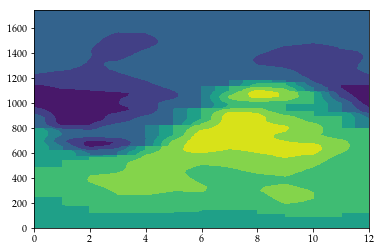

In [66]:
py.contourf(dm_by_dphi[0,...])

### Saving diffusivity for climlab for total transport

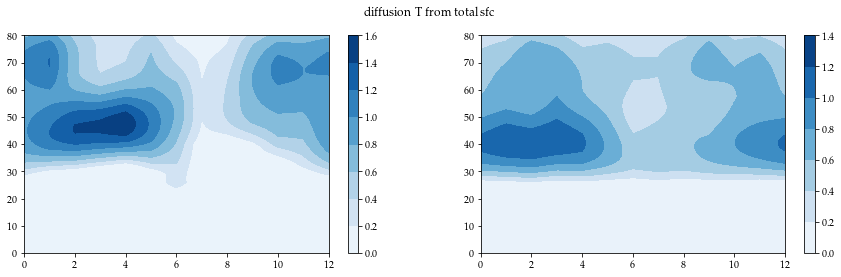

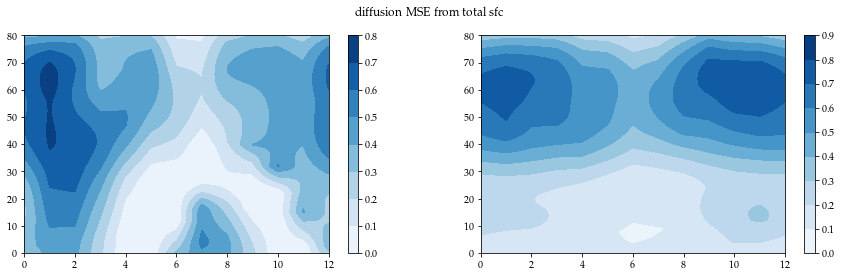

In [67]:
import numpy.ma as ma

level=1

def add_month(y):
    return np.append(y,y[...,0,None],axis=-1)

def save_from_zero_error(threshold,y):
    ind=(np.where((y<threshold) & (y>0)))
    y[ind]=threshold
    ind=(np.where((y>-1*threshold) & (y<0)))
    y[ind]=-1*threshold
    return y

def remove_negative(threshold,y):
    ind=(np.where((y<threshold)))
    y[ind]=threshold
    return y

def smooth_multi(y, box_pts,smoothing=1,ax=1):
    box = np.ones(box_pts)/box_pts
    y_smooth=np.apply_along_axis(np.convolve, ax, y, box, mode='same')
    if smoothing == 1 :
        return y_smooth
    else :
        return y

Tv   = add_month(T)
divT = spher_div_vert(Tv)
divMSE_all = spher_div_vert(add_month(Cp*T+g*Z+L*q))

import numpy.ma as ma

threshold               = 0.0001

dm_by_dphi              = divMSE_all[...,level,:]
dm_by_dphi              = save_from_zero_error(0.004,dm_by_dphi)
dT_by_dphi              = divT[...,level,:]
dT_by_dphi              = save_from_zero_error(0.000002,dT_by_dphi)

# not_mask_of_TE_all      = ma.masked_less(TE, threshold)  ### Positive transient eddies
# masked_TE_all           = ma.masked_where( ma.getmask(not_mask_of_TE_all), TE)

diffus_sfc_mse          = -add_month(TE+SE+MM)*10**15/(2*np.pi*a**3*np.cos(np.deg2rad(lat[None,:,None]))*dm_by_dphi)
diffus_sfc_mse          = remove_negative(0.00001,smooth_multi(diffus_sfc_mse,200))
diffus_sfc_T            = -add_month(TE_sens+SE_sens+MM_sens)*10**15/(2*np.pi*a**3*np.cos(np.deg2rad(lat[None,:,None]))*dT_by_dphi)
diffus_sfc_T            = remove_negative(0.0001,smooth_multi(diffus_sfc_T,200))

py.rc('text', usetex=True)
diffusion_data = {
    "lat"            : lat,
    "divT"           : divT,
    "T"              : Tv,
    "MSE"            : add_month(Cp*T+g*Z+L*q),
    "dm_by_dphi"     : dm_by_dphi,
    "dT_by_dphi"     : dT_by_dphi,
    "diffus_sfc_mse" : diffus_sfc_mse,
    "diffus_sfc_T"   : diffus_sfc_T,
    "heat_flux_PW"   : add_month(TE),
    "heat_flux_Wm-1" : add_month(TE)*10**15/(2*np.pi*a*np.cos(np.deg2rad(lat[None,:,None]))), 
    "MSE_flux_PW"   : add_month(TE+SE+MM),
    "MSE_flux_Wm-1" : add_month(TE_sens+SE_sens+MM_sens)*10**15/(2*np.pi*a*np.cos(np.deg2rad(lat[None,:,None]))),   
}

make_sure_path_exists("/project2/tas1/pragallva/climlab/data/")
# save("/project2/tas1/pragallva/climlab/data/diffusion_data_from_total_transport.hkl", diffusion_data)
py.figure(figsize=(15,4))
py.subplot(1,2,1)
py.ylim(0,80)
py.contourf(range(13), lat, diffus_sfc_T[0,...], cmap= cm.Blues ); py.colorbar()
py.subplot(1,2,2)
py.contourf(range(13), lat, diffus_sfc_T[1,...], cmap= cm.Blues ); py.colorbar()
py.ylim(0,80)
py.suptitle("diffusion T from total sfc")

py.figure(figsize=(15,4))
py.subplot(1,2,1)
py.ylim(0,80)
py.contourf(range(13), lat, Cp*diffus_sfc_mse[0,...], cmap= cm.Blues ); py.colorbar()
py.subplot(1,2,2)
py.contourf(range(13), lat, Cp*diffus_sfc_mse[1,...], cmap= cm.Blues ); py.colorbar()
py.ylim(0,80)
py.suptitle("diffusion MSE from total sfc")

In [68]:
# py.contourf(range(13), lat, spher_div_vert(Tv)[0,...,level,:],30, cmap=cm.seismic); py.colorbar()

In [69]:
# py.plot(lat,spher_div_vert(Tv)[0,...,level,:].mean(axis=-1))

In [70]:
# py.plot(lat,(Tv)[0,...,level,:-1].mean(axis=-1)-(Tv)[0,...,level,:].mean())
# py.plot(lat,spher_div_vert(Tv)[0,...,level,:-1].mean(axis=-1)*1000000)
# py.axhline(0)

### Calculate diffusivity as in Mbengue and Schneider, 2018

In [71]:
PF = 5
so='/project2/tas1/pragallva/Winter_quarter_2019/codes/python_scripts/miscellaneous/Paper_figures_ISCA/'
pressure_info=load(so+"pressure.hkl")
weights  = pressure_info["weights"]
pressure = pressure_info["pressure"][:,:,::-1,:]
psfc     = pressure_info["psfc"]

weights_a, pressure_a, weights_a, weights_a, weights_a, lat_a = N_S_avg(weights, pressure, weights, weights, weights, lat, flux_flag=1)

def save_from_zero_error(threshold,y):
    ind=(np.where((y<threshold) & (y>0)))
    y[ind]=threshold
    ind=(np.where((y>-1*threshold) & (y<0)))
    y[ind]=-1*threshold
    return y

def add_month(y):
    y1 = np.append(y,y[...,None,0],axis=-1)
    return y1

def vert_int(y, pi=2, pf=-10):
    integral = (y*weights_a)[...,pi:pf,:].sum(axis=-2)
    average  = (y*weights_a)[...,pi:pf,:].mean(axis=-2)/(weights_a)[...,pi:pf,:].mean(axis=-2)
    return integral, average

def vert_int1(y, pi=0, pf=-10):
    integral = (y*weights)[...,pi:pf,:].sum(axis=-2)
    average  = (y*weights)[...,pi:pf,:].sum(axis=-2)/(weights)[...,pi:pf,:].sum(axis=-2)
    return integral, average

Tv=add_month(T)
divT       = spher_div_vert(Tv)
divMSE_all = spher_div_vert(add_month(Cp*T+g*Z+L*q))

#eddy_sensible_heat      = (10**15*TEsensv[...,0:PF,:].sum(axis=2))/(Cp*2*np.pi*R*np.cos(np.deg2rad(lat[None,:,None])))
eddy_sensible_heat      = (10**15*TEv[...,0:PF,:].sum(axis=2))/(2*np.pi*R*np.cos(np.deg2rad(lat[None,:,None])))


#### This compares flux, gradients and their ratios, SUMMED over all levels, and lower 5 levels (0.1 - 7.8 sigma level)
#### Basically similar to Mbengue and Schneider, 2018

In [75]:
# d=0
# py.figure(figsize=(15,4))
# divMSE_all_v   = vert_int1(np.copy(divMSE_all1), 0, PF)[0]
# field=np.copy(TE); threshold1=0.3
# py.subplot(1,3,1)
# mask_of_TE      = ma.masked_inside(field,  -threshold1, threshold1)
# masked_TE1      = ma.masked_where(ma.getmask(mask_of_TE), np.copy(field))
# py.contourf(range(12), lat, np.copy(TE)[d,...], 10, cmap=cm.RdBu_r)
# py.colorbar()


# field=np.copy(divMSE_all_v); threshold1=0.001
# py.subplot(1,3,2)
# mask_of_TE      = ma.masked_inside(field,  -threshold1, threshold1)
# masked_TE2      = ma.masked_where( ma.getmask(mask_of_TE), np.copy(field))
# py.contourf(range(12), lat, np.copy(divMSE_all_v)[d,...], 10, cmap=cm.RdBu_r)
# py.colorbar()

# D = -(np.copy(TE)/np.copy(divMSE_all_v))
# ind = ((lat>30) & (lat<70))
# extratropics_N = D[...,ind,:]
# ind = ((lat<-30) & (lat>-70))
# extratropics_S = D[...,ind,:]
# threshold = max(np.max(extratropics_N),np.max(extratropics_S))
# positive_D = ma.masked_less_equal(D, 0)
# positive_D1 = ma.masked_greater_equal(positive_D, threshold)

# py.subplot(1,3,3)
# py.contourf(range(12), lat, positive_D1[d,...],  cmap=cm.Reds)
# py.colorbar()
# py.tight_layout()


In [100]:
def masked_D(field,gradient,d=0,box_pts=100):
    
    if d==0 :
        phi_h=25;
        tropics = ((lat>-phi_h) & (lat<phi_h))  
        print phi_h
    else:
        phi_h=20;
        tropics = ((lat>-phi_h) & (lat<phi_h))  
        print phi_h
            
    D = -(field/gradient)[d,...]
    
    positive_D  = ma.masked_less_equal(D, 0)                   ### Mask out all negativity Diffusivity
    positive_D[tropics,:] = np.nanmin(positive_D)                ### Makes tropics = 0 
    
    ## find the threshold condition ##
    ind = ((lat>35) & (lat<70))
    extratropics_N = (positive_D)[ind,:]
    ind = ((lat<-35) & (lat>-70))
    extratropics_S = (positive_D)[ind,:]
    threshold = max(np.nanmax(extratropics_N),np.nanmax(extratropics_S))
    ## find the threshold condition ##
    
#     print threshold, np.nanmax(extratropics_N), np.nanmax(extratropics_S)
    positive_D1 = ma.masked_greater_equal(positive_D, threshold)  ### Remove unnecessary spikes due to division 0    
    
    return smooth_multi(positive_D1,box_pts=box_pts,smoothing=1,ax=0)

In [101]:
# masked_D(field,gradient,d=0, box_pts=50)[0].shape

25
25
20


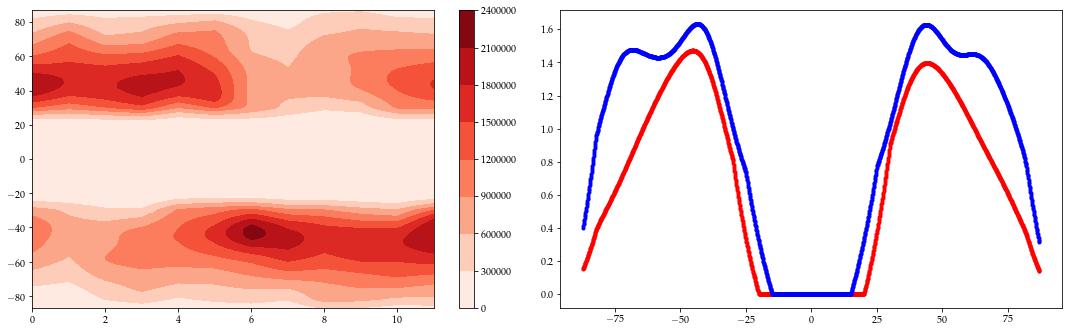

In [102]:
#smooth_multi(y, box_pts,smoothing=1,ax=1)

def smooth_multi(y, box_pts,smoothing=1,ax=1):
    box = np.ones(box_pts)/box_pts
    y_smooth=np.apply_along_axis(np.convolve, ax, y, box, mode='same')
    if smoothing == 1 :
        return y_smooth
    else :
        return y

#smooth_multi(y, box_pts,smoothing=1,ax=1)

def smooth_multi(y, box_pts,smoothing=1,ax=1):
    box = np.ones(box_pts)/box_pts
    y_smooth=np.apply_along_axis(np.convolve, ax, y, box, mode='same')
    if smoothing == 1 :
        return y_smooth
    else :
        return y
    
PF = 5
   
SMOOTH  = 100
divCpT1        = (spher_div_vert1(Cp*T,SMOOTH))
divMSE_all1    = (spher_div_vert1(Cp*T+g*Z+L*q,SMOOTH))  
divCpT_v1A     = vert_int1(np.copy(divCpT1), 0, -1)[0]
divMSE_all_v1A = vert_int1(np.copy(divMSE_all1), 0, -1)[0]
divCpT_v1L     = vert_int1(np.copy(divCpT1), 0, PF)[0]
divMSE_all_v1L = vert_int1(np.copy(divMSE_all1), 0, PF)[0]


field    = 10**15*TE/(2*np.pi*R)
gradient = divMSE_all_v1A

py.figure(figsize=(15,9))

py.subplot(2,2,1)
py.contourf(range(12), lat, masked_D(field,gradient,d=0, box_pts=100),  cmap=cm.Reds)
py.colorbar()

py.subplot(2,2,2)
py.plot(lat, np.nanmean(masked_D(field,gradient,d=0, box_pts=100),axis=-1)/10**6, 'r.')
py.plot(lat, np.nanmean(masked_D(field,gradient,d=1, box_pts=100),axis=-1)/10**6, 'b.')

py.tight_layout()

In [103]:
# D_sensA  = masked_D((10**15*TE_sens/(2*np.pi*R*np.cos(np.deg2rad(lat[None,:,None])))),(divCpT_v1A),d=0, box_pts=200)
# D_totalA = masked_D((10**15*TEtotalv/(2*np.pi*R*np.cos(np.deg2rad(lat[None,:,None,None])))).sum(axis=-2),(divMSE_all_v1A),d=0, box_pts=200)
# D_sensL  = masked_D((10**15*TEsensv/(2*np.pi*R*np.cos(np.deg2rad(lat[None,:,None,None]))))[:,:,0:PF,:].sum(axis=-2),(divCpT_v1L),d=0, box_pts=200)
# D_totalL = masked_D((10**15*TEtotalv/(2*np.pi*R*np.cos(np.deg2rad(lat[None,:,None,None]))))[:,:,0:PF,:].sum(axis=-2),(divMSE_all_v1L),d=0, box_pts=200)

# py.subplot(1,2,1)
# py.axhline(0)
# py.plot(lat, D_sensA[0].mean(axis=-1)/10**6,  'r-',    label='D sens all')
# py.plot(lat, D_totalA[0].mean(axis=-1)/10**6, 'k-',    label='D total all')
# py.plot(lat, D_sensL[0].mean(axis=-1)/10**6,  'r--',   label='D sens lower levels')
# py.plot(lat, D_totalL[0].mean(axis=-1)/10**6, 'k--',   label='D total lower levels')

# py.subplot(1,2,2)
# py.axhline(0)
# py.plot(lat, D_sensA[1].mean(axis=-1)/10**6,  'r-',    label='D sens all')
# py.plot(lat, D_totalA[1].mean(axis=-1)/10**6, 'k-',    label='D total all')
# py.plot(lat, D_sensL[1].mean(axis=-1)/10**6,  'r--',   label='D sens lower levels')
# py.plot(lat, D_totalL[1].mean(axis=-1)/10**6, 'k--',   label='D total lower levels')



25
25


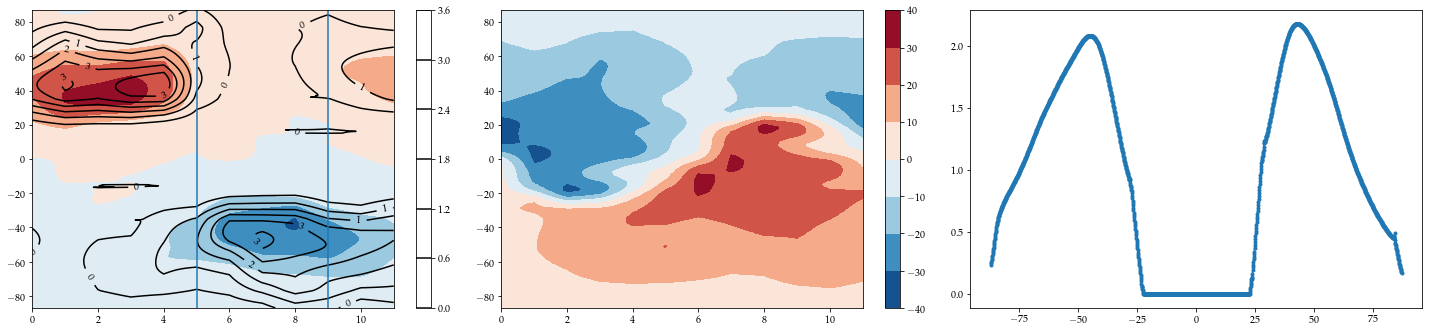

In [104]:
#smooth_multi(y, box_pts,smoothing=1,ax=1)

def smooth_multi(y, box_pts,smoothing=1,ax=1):
    box = np.ones(box_pts)/box_pts
    y_smooth=np.apply_along_axis(np.convolve, ax, y, box, mode='same')
    if smoothing == 1 :
        return y_smooth
    else :
        return y
   
SMOOTH  = 100
divCpT1        = (spher_div_vert1(Cp*T,SMOOTH))
divMSE_all1    = (spher_div_vert1(Cp*T+g*Z+L*q,SMOOTH))  
divCpT_v1A     = vert_int1(np.copy(divCpT1), 0, -1)[0]
divMSE_all_v1A = vert_int1(np.copy(divMSE_all1), 0, -1)[0]
divCpT_v1L     = vert_int1(np.copy(divCpT1), 0, PF)[0]
divMSE_all_v1L = vert_int1(np.copy(divMSE_all1), 0, PF)[0]


#np.cos(np.deg2rad(lat[None,:,None,None]))
# field    = (10**15*TEsensv/(2*np.pi*R*1))[:,:,0:PF,:].sum(axis=-2)
# gradient = np.copy((divCpT_v1L))


# field    = (10**15*TEtotalv/(2*np.pi*R*1)).sum(axis=-2)
# gradient = np.copy((divMSE_all_v1A))


# field    = (10**15*TEsensv/(2*np.pi*R*1))[:,:,0:PF,:].sum(axis=-2)
# gradient = np.copy((divCpT_v1L))


field    = (10**15*TEtotalv/(2*np.pi*R*1))[:,:,0:PF,:].sum(axis=-2)
gradient = np.copy((divMSE_all_v1L))


py.figure(figsize=(20,9))

py.subplot(2,3,1)
py.contourf(range(12), lat, field[0,...],  cmap=cm.RdBu_r)
c=py.contour(range(12), lat, (masked_D(field,gradient,d=0, box_pts=200))/10**6,  colors='k')
py.clabel(c,fmt="%1d")
py.axvline(5)
py.axvline(9)
py.colorbar()

py.subplot(2,3,2)
py.contourf(range(12), lat, gradient[0,...],  cmap=cm.RdBu_r)
py.colorbar()


py.subplot(2,3,3)
py.plot(lat, np.nanmean(masked_D(field,gradient,d=0, box_pts=50),axis=-1)/10**6, '.-')


py.tight_layout()
# py.suptitle(str(threshold), y=1.05)


25
20
25
20
25
20
25
20


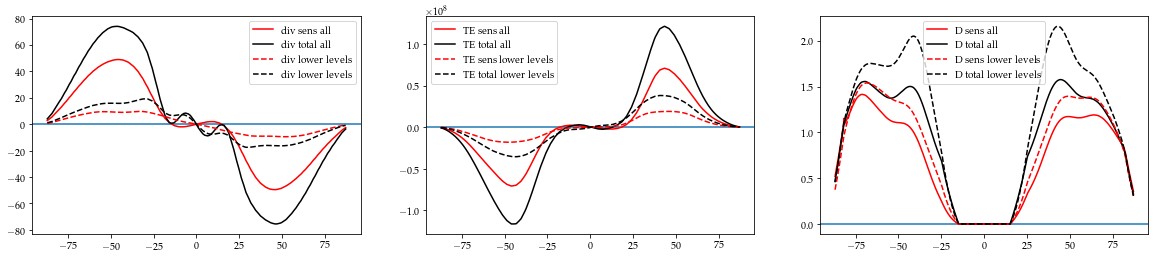

In [105]:
PF=5; d=0; SMOOTH=100
threshold=20
py.figure(figsize=(20,4))

py.subplot(1,3,1)
py.axhline(0)
divCpT1        = (spher_div_vert1(Cp*T,SMOOTH))
divMSE_all1    = (spher_div_vert1(Cp*T+g*Z+L*q,SMOOTH))

divCpT_v1A     = vert_int1(np.copy(divCpT1), 0, -1)[0]
divMSE_all_v1A = vert_int1(np.copy(divMSE_all1), 0, -1)[0]

py.plot(lat, divCpT_v1A[d,:,:].mean(axis=-1),    'r',        label='div sens all')
py.plot(lat, divMSE_all_v1A[d,:,:].mean(axis=-1),  'k',   label='div total all')

divCpT_v1L     = vert_int1(np.copy(divCpT1), 0, PF)[0]
divMSE_all_v1L = vert_int1(np.copy(divMSE_all1), 0, PF)[0]

py.plot(lat, divCpT_v1L[d,:,:].mean(axis=-1) ,         'r--',   label='div lower levels')
py.plot(lat, divMSE_all_v1L[d,:,:].mean(axis=-1) ,     'k--',   label='div lower levels')

py.legend(loc='best')

py.subplot(1,3,2)
py.axhline(0)
py.plot(lat, (10**15*TEsensv/(2*np.pi*R))[d,:,:,:].sum(axis=-2).mean(axis=-1),  'r-',    label='TE sens all')
py.plot(lat, (10**15*TEtotalv/(2*np.pi*R))[d,:,:,:].sum(axis=-2).mean(axis=-1),  'k-',    label='TE total all')
py.plot(lat, (10**15*TEsensv/(2*np.pi*R))[d,:,0:PF,:].sum(axis=-2).mean(axis=-1), 'r--',   label='TE sens lower levels')
py.plot(lat, (10**15*TEtotalv/(2*np.pi*R))[d,:,0:PF,:].sum(axis=-2).mean(axis=-1), 'k--',  label='TE total lower levels')
py.legend(loc='best')


# D_sensA  = np.array([masked_D((10**15*TEsensv/(2*np.pi*R)).sum(axis=-2),(divCpT_v1A),d=d, box_pts=SMOOTH) for d in range(2)])
# D_totalA = np.array([masked_D((10**15*TEtotalv/(2*np.pi*R)).sum(axis=-2),(divMSE_all_v1A),d=d, box_pts=SMOOTH) for d in range(2)])
# D_sensL  = np.array([masked_D((10**15*TEsensv/(2*np.pi*R))[:,:,0:PF,:].sum(axis=-2),(divCpT_v1L),d=d, box_pts=SMOOTH) for d in range(2)])
# D_totalL = np.array([masked_D((10**15*TEtotalv/(2*np.pi*R))[:,:,0:PF,:].sum(axis=-2),(divMSE_all_v1L),d=d, box_pts=SMOOTH) for d in range(2)])

def vert_int1(y, pi=0, pf=-10):
    integral = (y*weights)[...,pi:pf,:].sum(axis=-2)
    average  = (y*weights)[...,pi:pf,:].mean(axis=-2)#/(weights)[...,pi:pf,:].mean(axis=-2)
    return integral, average


divCpT1        = (spher_div_vert1(Cp*T,SMOOTH))
divMSE_all1    = (spher_div_vert1(Cp*T+g*Z+L*q,SMOOTH))  

# divCpT_v1A     = vert_int1(np.copy(divCpT1), 0, -1)[0]
# divMSE_all_v1A = vert_int1(np.copy(divMSE_all1), 0, -1)[0]
# divCpT_v1L     = vert_int1(np.copy(divCpT1), 0, PF)[0]
# divMSE_all_v1L = vert_int1(np.copy(divMSE_all1), 0, PF)[0]

# D_sensA  = np.array([masked_D((10**15*TEsensv/(2*np.pi*R)).sum(axis=-2),(divCpT_v1A),d=d, box_pts=SMOOTH) for d in range(2)])
# D_totalA = np.array([masked_D((10**15*TEtotalv/(2*np.pi*R)).sum(axis=-2),(divMSE_all_v1A),d=d, box_pts=SMOOTH) for d in range(2)])
# D_sensL  = np.array([masked_D((10**15*TEsensv/(2*np.pi*R))[:,:,0:PF,:].sum(axis=-2),(divCpT_v1L),d=d, box_pts=SMOOTH) for d in range(2)])
# D_totalL = np.array([masked_D((10**15*TEtotalv/(2*np.pi*R))[:,:,0:PF,:].sum(axis=-2),(divMSE_all_v1L),d=d, box_pts=SMOOTH) for d in range(2)])


divCpT_v1A     = vert_int1(np.copy(divCpT1), 0, -1)[1]
divMSE_all_v1A = vert_int1(np.copy(divMSE_all1), 0, -1)[1]
divCpT_v1L     = vert_int1(np.copy(divCpT1), 0, PF)[1]
divMSE_all_v1L = vert_int1(np.copy(divMSE_all1), 0, PF)[1]

D_sensA  = np.array([masked_D((10**15*TEsensv/(2*np.pi*R)).mean(axis=-2),(divCpT_v1A),d=d, box_pts=SMOOTH) for d in range(2)])
D_totalA = np.array([masked_D((10**15*TEtotalv/(2*np.pi*R)).mean(axis=-2),(divMSE_all_v1A),d=d, box_pts=SMOOTH) for d in range(2)])
D_sensL  = np.array([masked_D((10**15*TEsensv/(2*np.pi*R))[:,:,0:PF,:].mean(axis=-2),(divCpT_v1L),d=d, box_pts=SMOOTH) for d in range(2)])
D_totalL = np.array([masked_D((10**15*TEtotalv/(2*np.pi*R))[:,:,0:PF,:].mean(axis=-2),(divMSE_all_v1L),d=d, box_pts=SMOOTH) for d in range(2)])


d=1
py.subplot(1,3,3)
py.axhline(0)
py.plot(lat, np.nanmean(D_sensA[d,...],axis=-1)/10**6,  'r-',    label='D sens all')
py.plot(lat, np.nanmean(D_totalA[d,...],axis=-1)/10**6, 'k-',    label='D total all')
py.plot(lat, np.nanmean(D_sensL[d,...],axis=-1)/10**6,  'r--',   label='D sens lower levels')
py.plot(lat, np.nanmean(D_totalL[d,...],axis=-1)/10**6, 'k--',   label='D total lower levels')
py.legend(loc='best')

# print sigma_full[0:5]

## Convert $D_{mbengue}$ to $D_{isca}$

In [117]:
D_mbengue = np.copy(D_sensL)
W05       = (weights)[...,0:PF,:].mean(axis=-2)
D_isca    = D_mbengue*(2*np.pi*R)*W05

## Convert $D_{mbengue}$ to $D_{ebm}$

In [119]:
D_ebm1 = D_mbengue*Cp*W05/R**2
D_ebm2 = D_isca*Cp/((2*np.pi*R**3))#*np.cos(np.deg2rad(lat[None,:, None])))

## Define functions to calculate Dmbengue, Disca and Debm

In [185]:
def barpanda_rose(D_mbengue=0, PF=-1):
    W05         = (weights)[...,0:PF,:].sum(axis=-2)
    barpanda    = D_mbengue*(2*np.pi*R)*W05
    rose        = D_mbengue*Cp*W05/R**2
    return barpanda, rose

D_sensA  = np.array([masked_D((10**15*TEsensv/(2*np.pi*R)).mean(axis=-2),(divCpT_v1A),d=d, box_pts=SMOOTH) for d in range(2)])
D_mseA = np.array([masked_D((10**15*TEtotalv/(2*np.pi*R)).mean(axis=-2),(divMSE_all_v1A),d=d, box_pts=SMOOTH) for d in range(2)])
D_sensL  = np.array([masked_D((10**15*TEsensv/(2*np.pi*R))[:,:,0:PF,:].mean(axis=-2),(divCpT_v1L),d=d, box_pts=SMOOTH) for d in range(2)])
D_mseL = np.array([masked_D((10**15*TEtotalv/(2*np.pi*R))[:,:,0:PF,:].mean(axis=-2),(divMSE_all_v1L),d=d, box_pts=SMOOTH) for d in range(2)])

Mbengue  = {"D_sensA": D_sensA,                   "D_mseA": D_mseA ,                  "D_mseL": D_mseL,                     "D_sensL": D_sensL }
Barpanda = {"D_sensA": barpanda_rose(D_sensA)[0], "D_mseA": barpanda_rose(D_mseA)[0], "D_mseL": barpanda_rose(D_mseL,5)[0], "D_sensL": barpanda_rose(D_sensL,5)[0]}
Brian    = {"D_sensA": barpanda_rose(D_sensA)[1], "D_mseA": barpanda_rose(D_mseA)[1], "D_mseL": barpanda_rose(D_mseL,5)[1], "D_sensL": barpanda_rose(D_sensL,5)[1]}

Diffusivity_data_from_mbengue = {'Mbengue':Mbengue, 'Barpanda':Barpanda, 'Brian': Brian}


### Now calculate for Isca and then convert it to Mbengue and Brian

In [186]:
def masked_D(field,gradient,d=0,box_pts=100):
    
    if d==0 :
        phi_h=30;
        tropics = ((lat>-phi_h) & (lat<phi_h))  
#         print phi_h
    else:
        phi_h=20;
        tropics = ((lat>-phi_h) & (lat<phi_h))  
#         print phi_h
            
    D = -(field/gradient)[d,...]
    
    positive_D  = ma.masked_less_equal(D, 0)                   ### Mask out all negativity Diffusivity
    positive_D[tropics,:] = np.nanmin(positive_D)                ### Makes tropics = 0 
    
    ## find the threshold condition ##
    ind = ((lat>35) & (lat<70))
    extratropics_N = (positive_D)[ind,:]
    ind = ((lat<-35) & (lat>-70))
    extratropics_S = (positive_D)[ind,:]
    threshold = max(np.nanmax(extratropics_N),np.nanmax(extratropics_S))
    ## find the threshold condition ##
    
#     print threshold, np.nanmax(extratropics_N), np.nanmax(extratropics_S)
    positive_D1 = ma.masked_greater_equal(positive_D, threshold)  ### Remove unnecessary spikes due to division 0    
    
    return smooth_multi(positive_D1,box_pts=box_pts,smoothing=1,ax=0)

In [218]:
def mbengue_rose(D_isca=0, PF=-1):
    W05         = (weights)[...,0:PF,:].sum(axis=-2)
    mbengue     = D_isca/((2*np.pi*R)*W05)
    rose        = np.copy(mbengue)*Cp*W05/R**2
    return mbengue, rose

SMOOTH=50

divCpT1        = (spher_div_vert1(Cp*T,SMOOTH))
divMSE_all1    = (spher_div_vert1(Cp*T+g*Z+L*q,SMOOTH))  

SMOOTH=100

Di_sensA       = np.array([masked_D((10**15*TEsensv).sum(axis=-2),(divCpT1)[...,1,:],                  d=d, box_pts=SMOOTH) for d in range(2)])
Di_mseA        = np.array([masked_D((10**15*TE),(divMSE_all1)[...,1,:],                                d=d, box_pts=SMOOTH) for d in range(2)])
Di_sensL       = np.array([masked_D((10**15*TEsensv)[:,:,0:PF,:].mean(axis=-2),(divCpT1)[...,1,:],     d=d, box_pts=SMOOTH) for d in range(2)])
Di_mseL        = np.array([masked_D((10**15*TEtotalv)[:,:,0:PF,:].mean(axis=-2),(divMSE_all1)[...,1,:],d=d, box_pts=SMOOTH) for d in range(2)])

Barpanda1  = {"D_sensA": Di_sensA,                  "D_mseA": Di_mseA,                  "D_mseL": Di_mseL,                      "D_sensL": Di_sensL }
Mbengue1   = {"D_sensA": mbengue_rose(Di_sensA)[0], "D_mseA": mbengue_rose(Di_mseA)[0], "D_mseL": mbengue_rose(Di_mseL,5)[0],   "D_sensL": mbengue_rose(Di_sensL,5)[0]}
Brian1     = {"D_sensA": mbengue_rose(Di_sensA)[1], "D_mseA": mbengue_rose(Di_mseA)[1], "D_mseL": mbengue_rose(Di_mseL,5)[1],   "D_sensL": mbengue_rose(Di_sensL,5)[1]}

Diffusivity_data_from_barpanda = {'Mbengue':Mbengue1, 'Barpanda':Barpanda1, 'Brian': Brian1}




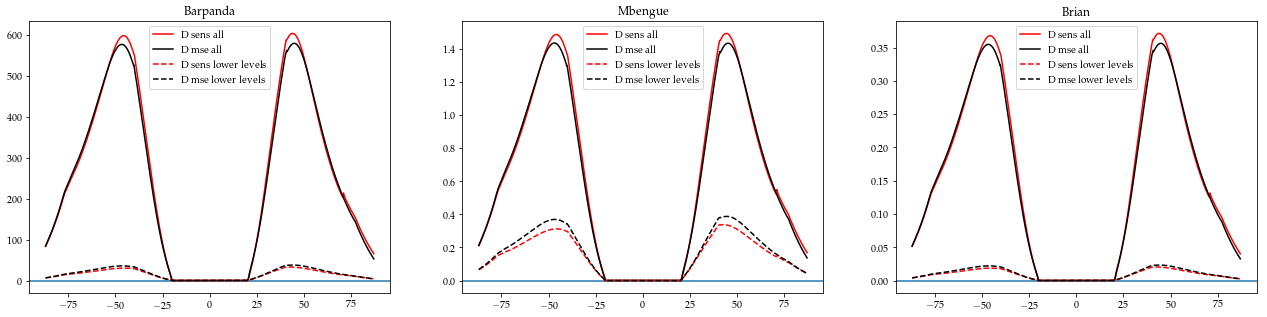

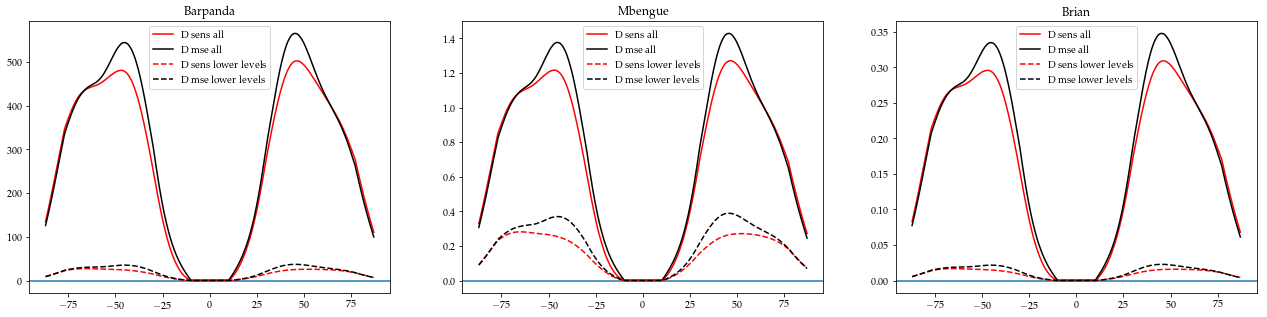

In [188]:

def plot_compare_diffs(Y=Mbengue1, d=0, scale=10**6):
    py.plot(lat, np.nanmean((Y['D_sensA'])[d,...],axis=-1)/scale,  'r-',  label='D sens all')
    py.plot(lat, np.nanmean((Y['D_mseA'])[d,...],axis=-1)/scale, 'k-',    label='D mse all')
    py.plot(lat, np.nanmean((Y['D_sensL'])[d,...],axis=-1)/scale,  'r--', label='D sens lower levels')
    py.plot(lat, np.nanmean((Y['D_mseL'])[d,...],axis=-1)/scale, 'k--',   label='D mse lower levels')
    

py.figure(figsize=(22,5))
d=0
py.subplot(1,3,1)
py.axhline(0)
plot_compare_diffs(Y=Barpanda1, d=d, scale=10**15)
py.legend(loc='best')
py.title("Barpanda")

py.subplot(1,3,2)
py.axhline(0)
plot_compare_diffs(Y=Mbengue1, d=d, scale=10**6)
py.legend(loc='best')
py.title("Mbengue")

py.subplot(1,3,3)
py.axhline(0)
plot_compare_diffs(Y=Brian1, d=d, scale=10**0)
py.legend(loc='best')
py.title("Brian")

py.figure(figsize=(22,5))
d=1
py.subplot(1,3,1)
py.axhline(0)
plot_compare_diffs(Y=Barpanda1, d=d, scale=10**15)
py.legend(loc='best')
py.title("Barpanda")

py.subplot(1,3,2)
py.axhline(0)
plot_compare_diffs(Y=Mbengue1, d=d, scale=10**6)
py.legend(loc='best')
py.title("Mbengue")

py.subplot(1,3,3)
py.axhline(0)
plot_compare_diffs(Y=Brian1, d=d, scale=10**0)
py.legend(loc='best')
py.title("Brian")




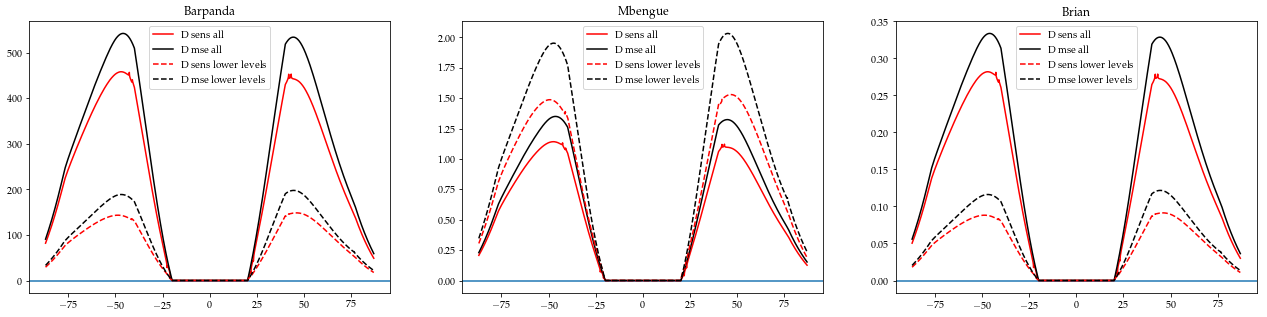

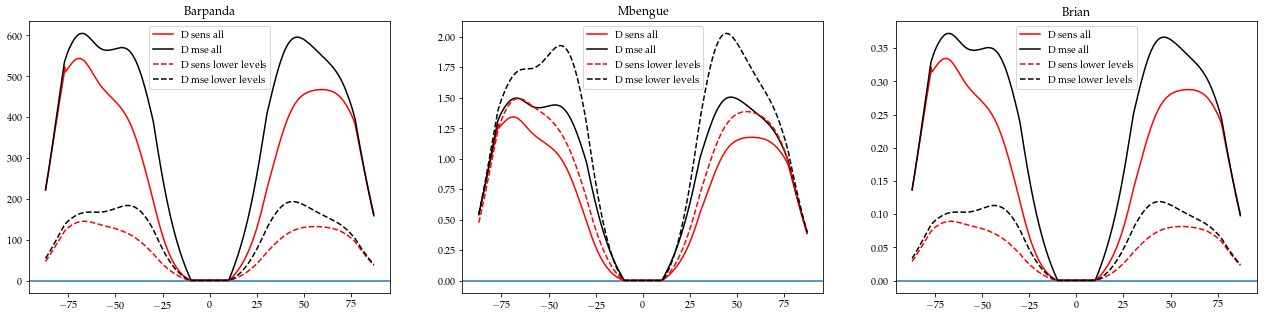

In [189]:

def plot_compare_diffs(Y=Mbengue1, d=0, scale=10**6):
    py.plot(lat, np.nanmean((Y['D_sensA'])[d,...],axis=-1)/scale,  'r-',  label='D sens all')
    py.plot(lat, np.nanmean((Y['D_mseA'])[d,...],axis=-1)/scale, 'k-',    label='D mse all')
    py.plot(lat, np.nanmean((Y['D_sensL'])[d,...],axis=-1)/scale,  'r--', label='D sens lower levels')
    py.plot(lat, np.nanmean((Y['D_mseL'])[d,...],axis=-1)/scale, 'k--',   label='D mse lower levels')
    

py.figure(figsize=(22,5))
d=0
py.subplot(1,3,1)
py.axhline(0)
plot_compare_diffs(Y=Barpanda, d=d, scale=10**15)
py.legend(loc='best')
py.title("Barpanda")

py.subplot(1,3,2)
py.axhline(0)
plot_compare_diffs(Y=Mbengue, d=d, scale=10**6)
py.legend(loc='best')
py.title("Mbengue")

py.subplot(1,3,3)
py.axhline(0)
plot_compare_diffs(Y=Brian, d=d, scale=10**0)
py.legend(loc='best')
py.title("Brian")

py.figure(figsize=(22,5))
d=1
py.subplot(1,3,1)
py.axhline(0)
plot_compare_diffs(Y=Barpanda, d=d, scale=10**15)
py.legend(loc='best')
py.title("Barpanda")

py.subplot(1,3,2)
py.axhline(0)
plot_compare_diffs(Y=Mbengue, d=d, scale=10**6)
py.legend(loc='best')
py.title("Mbengue")

py.subplot(1,3,3)
py.axhline(0)
plot_compare_diffs(Y=Brian, d=d, scale=10**0)
py.legend(loc='best')
py.title("Brian")




In [219]:
Diffusivity_data_from_mbengue  = {'Mbengue':Mbengue, 'Barpanda':Barpanda, 'Brian': Brian}
Diffusivity_data_from_barpanda = {'Mbengue':Mbengue1, 'Barpanda':Barpanda1, 'Brian': Brian1}
dest  =  "/project2/tas1/pragallva/climlab/data/"

save(filename = dest+"Diffusivity_data_from_mbengue.hkl", dictionary=Diffusivity_data_from_mbengue)
save(filename = dest+"Diffusivity_data_from_barpanda.hkl",dictionary=Diffusivity_data_from_barpanda)

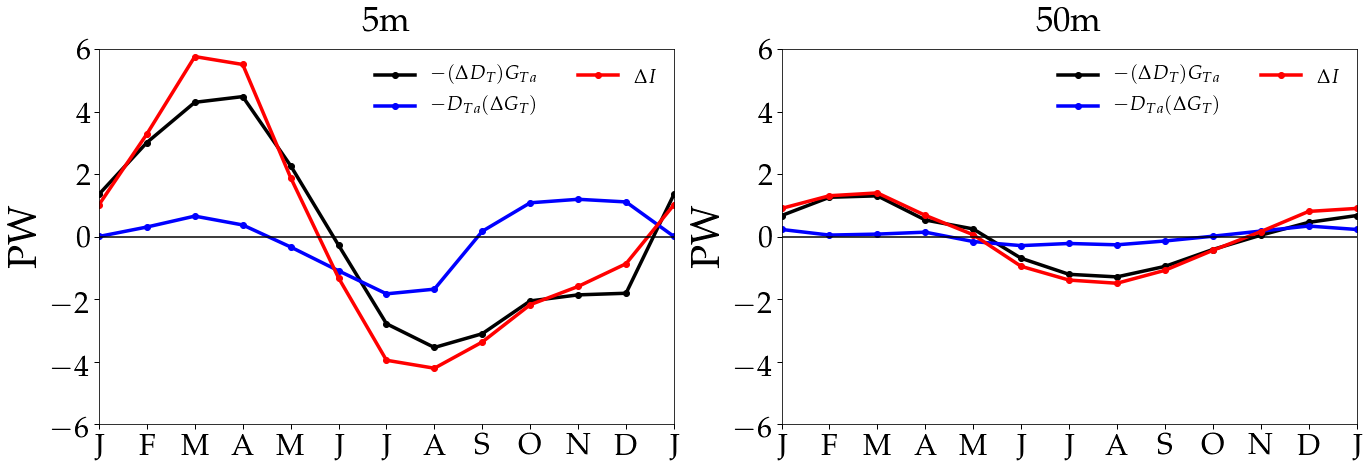

In [87]:
level=1
dm_by_dphi            = masked_div_MSE[...,level,:]
not_mask_of_TE_a      = ma.masked_less(TE_a, threshold)  ### Positive transient eddies
masked_TE_a           = ma.masked_where( ma.getmask(not_mask_of_TE_a), TE_a)
diffusivity_sfc       = -TE_a/dm_by_dphi


def mean(X):
     return X[...,:-1].mean(axis=-1)[...,None]
def prime(X):
    return X-mean(X)


D_mean =mean(diffusivity_sfc)
Im_mean=mean(dm_by_dphi)
I_mean =mean(TE_a)

D_prime =prime(diffusivity_sfc)
Im_prime=prime(dm_by_dphi)
I_prime =prime(TE_a)

i1= mean(D_prime*Im_prime)
i1= (np.asarray( [np.squeeze(i1)]*13).transpose(1,2,0))
i2= -1*D_prime*Im_prime
i3= -1*D_prime*Im_mean
i4= -1*D_mean*Im_prime

i1_a=inerp_at_max(i1,lat_a)
i2_a=inerp_at_max(i2,lat_a)
i3_a=inerp_at_max(i3,lat_a)
i4_a=inerp_at_max(i4,lat_a)

#i_a       =inerp_at_max(i_sum,lat_a)
# teprime_a=inerp_at_max(TE_prime,lat_a)
imain_a=inerp_at_max(TE_a,lat_a) 

l=6.0; i=0;
fig=py.figure(figsize=(38, 12))
for d in range(len(DEPTHS)):
    py.subplot(2,4,i+1)
    plot_at_storm_position(d,l,0)
#     py.plot((i3_a+i4_a)[d,:],'r--')
    i=i+1
    py.tight_layout()


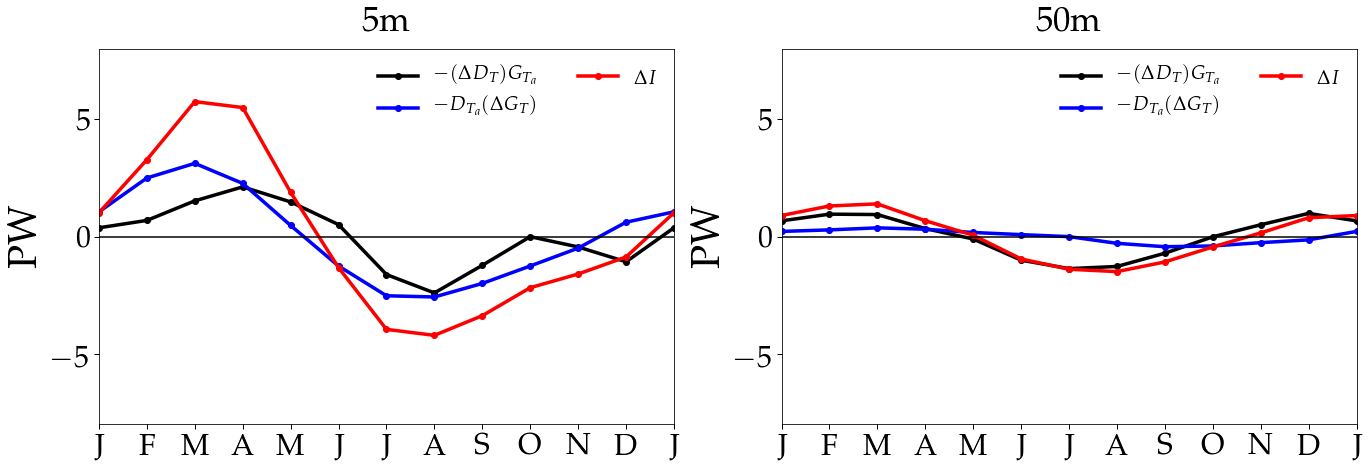

In [88]:
level=1
dCpT_by_dphi          = masked_div_CpT[...,level,:]
not_mask_of_TE_a      = ma.masked_less(TE_a, threshold)  ### Positive transient eddies
masked_TE_a           = ma.masked_where( ma.getmask(not_mask_of_TE_a), TE_a)
diffusivity_sfc       = -TE_a/dCpT_by_dphi

I3T=r'$-(\Delta D_T) G_{T_{a}}$'
I4T=r'$-D_{T_{a}} (\Delta G_T)$'


def mean(X):
     return X[...,:-1].mean(axis=-1)[...,None]
def prime(X):
    return X-mean(X)


D_mean =mean(diffusivity_sfc)
Im_mean=mean(dCpT_by_dphi)
I_mean =mean(TE_a)

D_prime =prime(diffusivity_sfc)
Im_prime=prime(dCpT_by_dphi)
I_prime =prime(TE_a)

i1= mean(D_prime*Im_prime)
i1= (np.asarray( [np.squeeze(i1)]*13).transpose(1,2,0))
i2= -1*D_prime*Im_prime
i3= -1*D_prime*Im_mean
i4= -1*D_mean*Im_prime

i1_a=inerp_at_max(i1,lat_a)
i2_a=inerp_at_max(i2,lat_a)
i3_a=inerp_at_max(i3,lat_a)
i4_a=inerp_at_max(i4,lat_a)

#i_a        = inerp_at_max(i_sum,lat_a)
# teprime_a = inerp_at_max(TE_prime,lat_a)

l=10.0; i=0;
fig=py.figure(figsize=(38, 12))
for d in range(len(DEPTHS)):
    py.subplot(2,4,i+1)
    plot_at_storm_position(d,l,0,f='T')
    i=i+1
    py.ylim(-8,8)
    py.tight_layout()


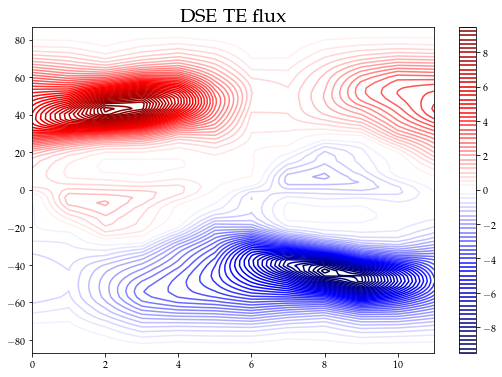

In [89]:
py.figure(figsize=(9,6))
py.contour(range(12), lat,  (TE_sens+TE_pot)[0,...], np.arange(-9.5,9.75,0.25),cmap=cm.seismic); py.colorbar()
py.title("DSE TE flux", fontsize=20)

In [90]:
def spher_div_vert1(x,N=50):
       fac=1#np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
        for p in range(len(sigma_full)):
          for m in range(12):
            div[d,:,p,m]= smooth(np.gradient((x[d,:,p,m])*(fac)/R,dtheta),N)
       return div
DSE_gradient=spher_div_vert1(Cp*T+g*Z)
MSE_gradient=spher_div_vert1(Cp*T+g*Z+L*q)



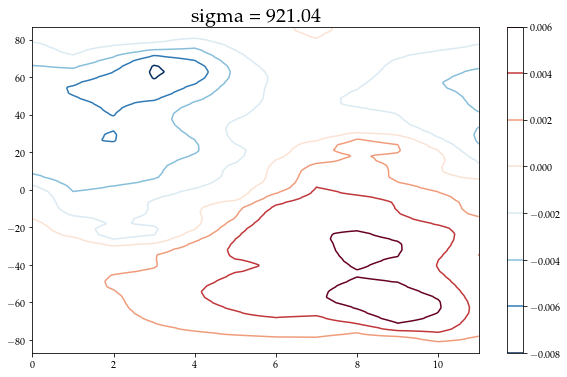

In [91]:
lev=1
py.figure(figsize=(10,6))
py.contour(range(12), lat,  spher_div_vert1(Cp*T+g*Z)[0,:,lev,:], cmap=cm.RdBu_r); py.colorbar()
py.title("sigma = %1.2f"%sigma_full[lev], fontsize=20)


In [92]:
def N_S_avg1(field, lat=lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90)) 
    l_S=((lat>=-90) & (lat<=0))
    

    avg = lambda x: (x[:,l_N,...]+flux_flag*np.roll(x[:,l_S,...][:,::-1,...], int(field.shape[-1]/2), axis=-1))/2.0  
    lat_a = lat[l_N]
        
    field1= avg(field)    
    
    return (field1), lat_a


In [93]:
lev=1
DSE_gradient  = save_from_zero_error(0.0022, spher_div_vert1(Cp*T+g*Z)[...,lev,:])
diffusive_DSE = (TE_sens+TE_pot)/DSE_gradient


lev=1
DSE_gradient  = save_from_zero_error(0.0022, spher_div_vert1(Cp*T)[...,lev,:])
diffusive_DSE = (TE_sens)/DSE_gradient

MSE_gradient  = save_from_zero_error(0.0025, spher_div_vert1(Cp*T+g*Z+L*q)[...,lev,:])
diffusive_MSE = (TE_sens+TE_pot+TE_moist)/MSE_gradient



div_TE_DSE     = spher_div(add_month(N_S_avg1(TE_sens+TE_pot)[0])*10**15, lat1=lat_a)
storm_pos_dse  = find_zero(div_TE_DSE)




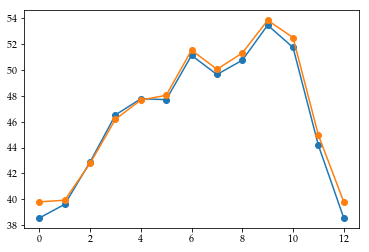

In [94]:
py.plot(storm_pos_dse[0],'o-')
py.plot(storm_pos[0],'o-')

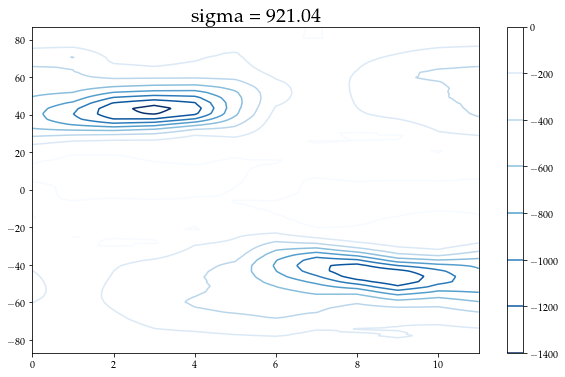

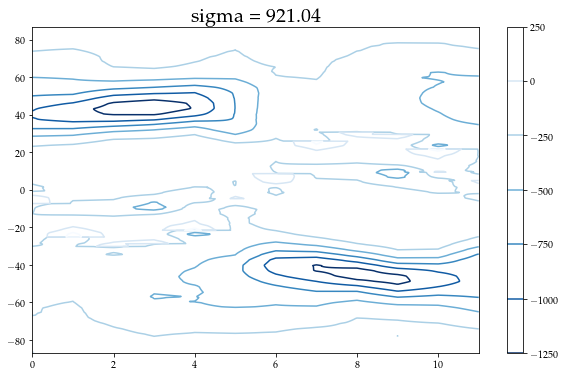

In [95]:
lev=1
py.figure(figsize=(10,6))
py.contour(range(12), lat,  diffusive_DSE[0,...],  cmap=cm.Blues_r); py.colorbar()
py.title("sigma = %1.2f"%sigma_full[lev], fontsize=20)

lev=1
py.figure(figsize=(10,6))
py.contour(range(12), lat,  diffusive_MSE[0,...],  cmap=cm.Blues_r); py.colorbar()
py.title("sigma = %1.2f"%sigma_full[lev], fontsize=20)

### Convert Isca diffusivity to Mbengue and EBM diffusivity units

In [96]:
lev=1;
ocheck=spher_div_vert1(Cp*T+g*Z+L*q)[...,lev,:]

In [92]:
PF      = -1
D_isca1 = -np.copy(diffusive_MSE)*10**15

NameError: name 'diffusive_MSE' is not defined

In [81]:
W05        = (weights)[...,0:PF,:].sum(axis=-2)
D_mbengue1 = np.copy(D_isca1)*( (2*np.pi*R*np.cos(np.deg2rad(lat[None,:,None])))*W05 )**-1
D_ebm1     = np.copy(D_isca1)*Cp*( (2*np.pi*R**3*np.cos(np.deg2rad(lat[None,:,None]))))**-1


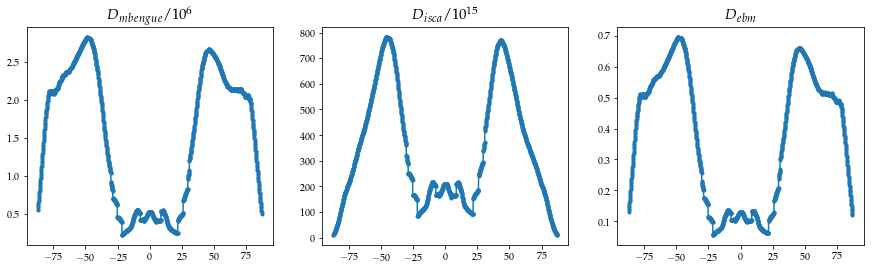

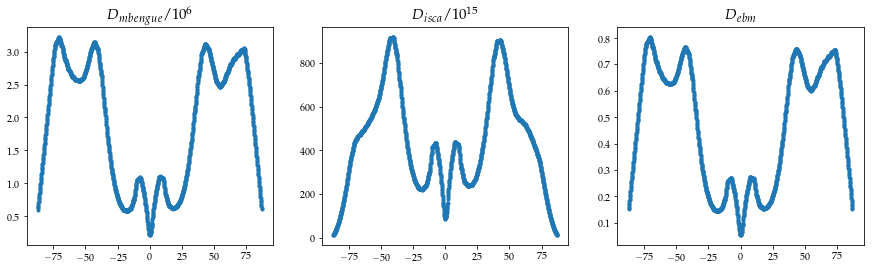

In [82]:
d=0
py.figure(figsize=(15,4))
py.subplot(1,3,1)
py.plot(lat,D_mbengue1[d,:,:].mean(axis=-1)/10**6, '.-')
py.title(r"$D_{mbengue}$/$10^{6}$", fontsize=15)
py.subplot(1,3,2)
py.plot(lat,D_isca1[d,:,:].mean(axis=-1)/10**15, '.-')
py.title(r"$D_{isca}$/$10^{15}$", fontsize=15)
py.subplot(1,3,3)
py.plot(lat,D_ebm1[d,:,:].mean(axis=-1), '.-')
py.title(r"$D_{ebm}$", fontsize=15)

d=1
py.figure(figsize=(15,4))
py.subplot(1,3,1)
py.plot(lat,D_mbengue1[d,:,:].mean(axis=-1)/10**6, '.-')
py.title(r"$D_{mbengue}$/$10^{6}$", fontsize=15)
py.subplot(1,3,2)
py.plot(lat,D_isca1[d,:,:].mean(axis=-1)/10**15, '.-')
py.title(r"$D_{isca}$/$10^{15}$", fontsize=15)
py.subplot(1,3,3)
py.plot(lat,D_ebm1[d,:,:].mean(axis=-1), '.-')
py.title(r"$D_{ebm}$", fontsize=15)

<a list of 18 text.Text objects>

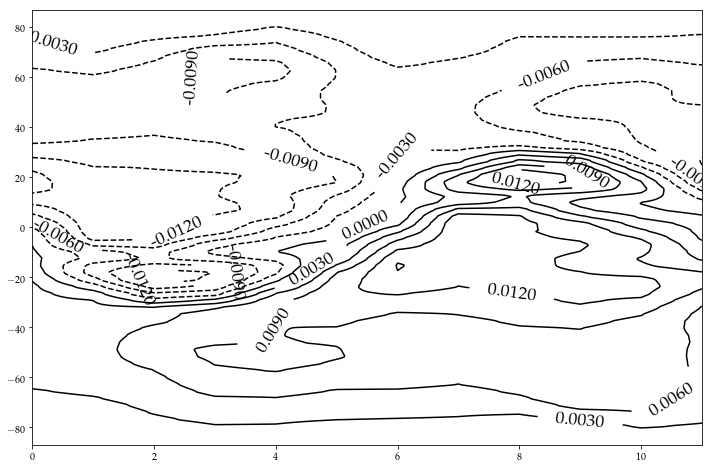

In [83]:
py.figure(figsize=(12,8))
c=py.contour(range(12), lat, ocheck[0,...], 10, colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.4f',inline_spacing=18, fontsize=18)

<a list of 16 text.Text objects>

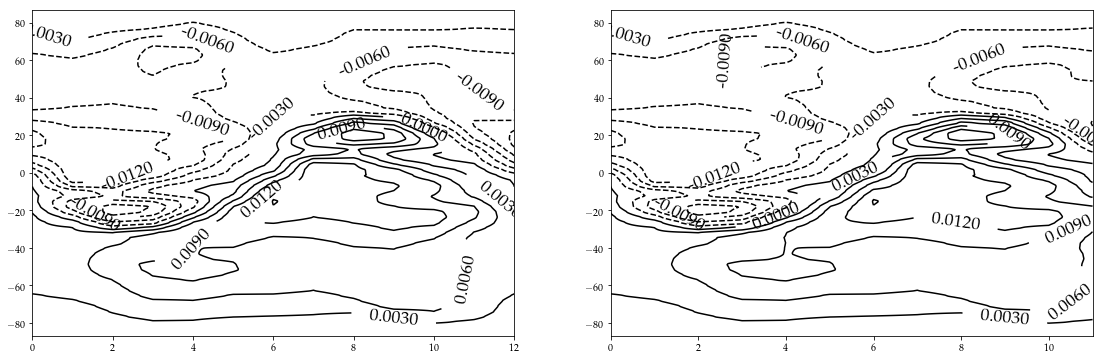

In [85]:
py.figure(figsize=(19,6))
py.subplot(1,2,1)
c=py.contour(range(13), lat, divMSE_all[0,:,1,:], 10, colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.4f',inline_spacing=18, fontsize=18)
py.subplot(1,2,2)
c=py.contour(range(12), lat, ocheck[0,:,:], 10, colors='k'); 
py.clabel(c,  inline=1,fmt = '%1.4f',inline_spacing=18, fontsize=18)

In [86]:
divMSE_all.shape

(2, 1741, 40, 13)

In [87]:
ocheck.shape

(2, 1741, 12)

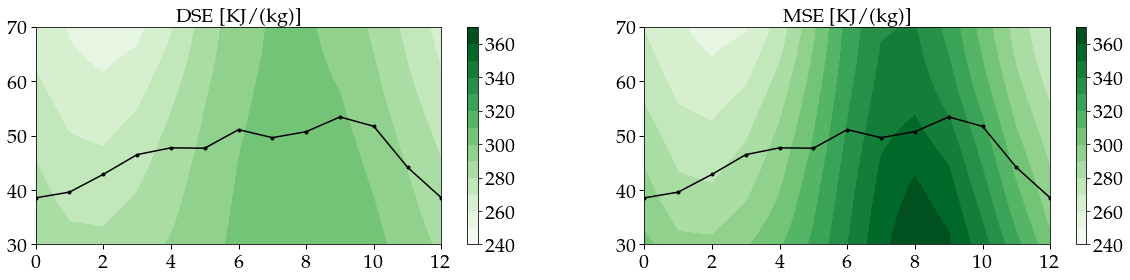

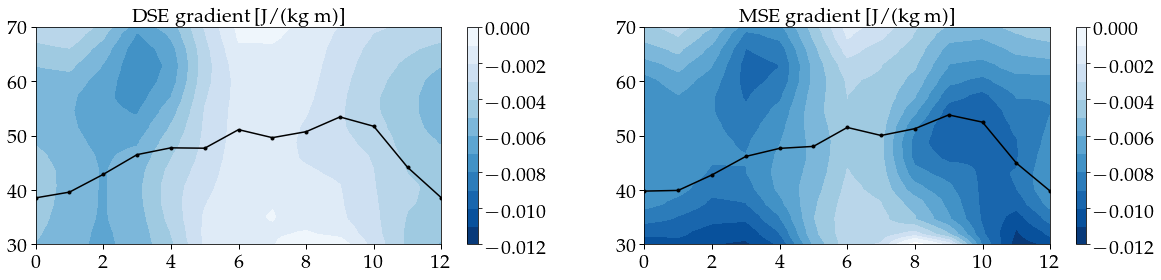

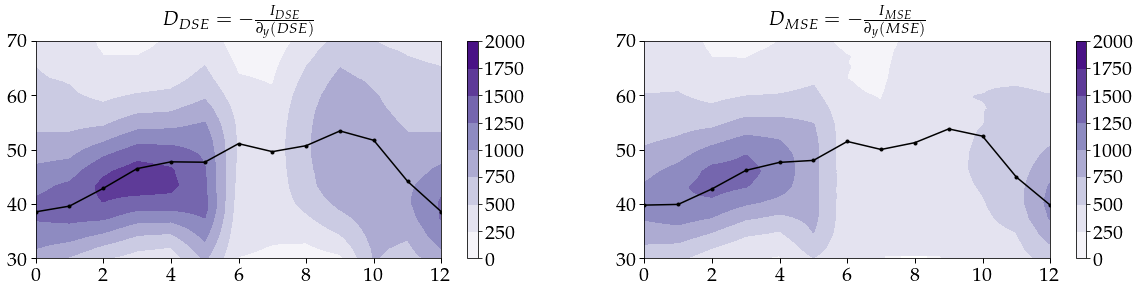

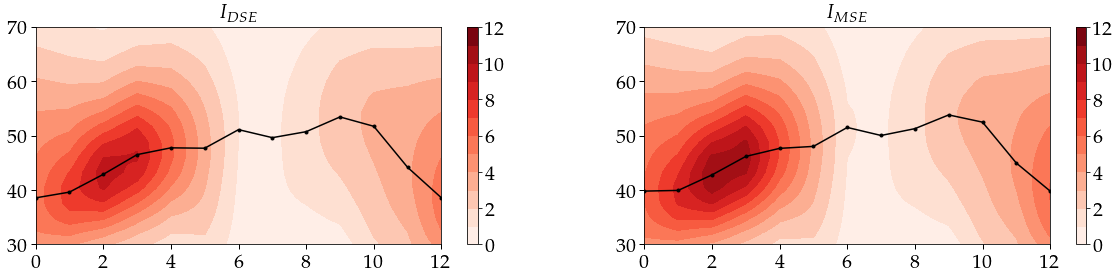

In [88]:
def spher_div_vert1(x,N=50):
       fac=1#np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
        for p in range(len(sigma_full)):
          for m in range(12):
            div[d,:,p,m]= smooth(np.gradient((x[d,:,p,m])*(fac)/R,dtheta),N)
       return div
 

lev=1; d=0
DSE_gradient  = save_from_zero_error(0.00002, (div_CpT+div_gZ)[...,lev,:])
diffusive_DSE = add_month(N_S_avg1(TE_sens+TE_pot)[0])/DSE_gradient
MSE_gradient  = save_from_zero_error(0.00002, (div_CpT+div_gZ+div_Lq)[...,lev,:])
diffusive_MSE = add_month(N_S_avg1(TE_sens+TE_pot+TE_moist)[0])/MSE_gradient

DSE=(CpTv_a+gZv_a)[...,lev,:]
MSE=(CpTv_a+gZv_a+Lqv_a)[...,lev,:]
py.figure(figsize=(20,4))
py.subplot(1,2,1)
py.contourf(range(13), lat_a, DSE[d,...]/1000, np.arange(240, 380, 10),  cmap=cm.Greens); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos_dse[0,:], 'k.-')
py.ylim(30,70)
py.title("DSE [KJ/(kg)]", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)

py.subplot(1,2,2)
py.contourf(range(13), lat_a, MSE[d,...]/1000, np.arange(240, 380, 10), cmap=cm.Greens); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos_dse[0,:], 'k.-')
py.ylim(30,70)
py.title("MSE [KJ/(kg)]", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)


py.figure(figsize=(20,4))
delit = 0.001
py.subplot(1,2,1)
py.contourf(range(13), lat_a, DSE_gradient[d,...], np.arange(-0.012, 0+delit, delit), cmap=cm.Blues_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos_dse[0,:], 'k.-')
py.ylim(30,70)
py.title("DSE gradient [J/(kg m)]", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)

py.subplot(1,2,2)
py.contourf(range(13), lat_a, MSE_gradient[d,...], np.arange(-0.012, 0+delit, delit), cmap=cm.Blues_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos[0,:], 'k.-')
py.ylim(30,70)
py.title("MSE gradient [J/(kg m)]", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)


DSE_gradient  = save_from_zero_error(0.0022, (div_CpT+div_gZ)[...,lev,:])
diffusive_DSE = add_month(N_S_avg1(TE_sens+TE_pot)[0])/DSE_gradient
MSE_gradient  = save_from_zero_error(0.0022, (div_CpT+div_gZ+div_Lq)[...,lev,:])
diffusive_MSE = add_month(N_S_avg1(TE_sens+TE_pot+TE_moist)[0])/MSE_gradient

py.figure(figsize=(20,4))
py.subplot(1,2,1)
py.contourf(range(13), lat_a, -diffusive_DSE[d,...], np.arange(0,1900+250,250), cmap=cm.Purples); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos_dse[d,:], 'k.-')
py.ylim(30,70)
py.title(r"$D_{DSE}=-\frac{I_{DSE}}{\partial_{y}(DSE)}$", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)

py.subplot(1,2,2)
py.contourf(range(13), lat_a, -diffusive_MSE[d,...], np.arange(0,1900+250,250), cmap=cm.Purples); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos[d,:], 'k.-')
py.ylim(30,70)
py.title(r"$D_{MSE}=-\frac{I_{MSE}}{\partial_{y}(MSE)}$", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)


py.figure(figsize=(20,4))
py.subplot(1,2,1)
py.contourf(range(13), lat_a, add_month(N_S_avg1(TE_sens+TE_pot)[0])[d,...], np.arange(0,13,1.0), cmap=cm.Reds); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos_dse[d,:], 'k.-')
py.plot(-np.roll(storm_pos_dse[0,:-1],6), 'k.-')
py.ylim(30,70)
py.title(r"$I_{DSE}$", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)


py.subplot(1,2,2)
py.contourf(range(13), lat_a, add_month(N_S_avg1(TE)[0])[d,...], np.arange(0,13,1.0),  cmap=cm.Reds); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos[d,:], 'k.-')
py.ylim(30,70)
py.title(r"$I_{MSE}$", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)

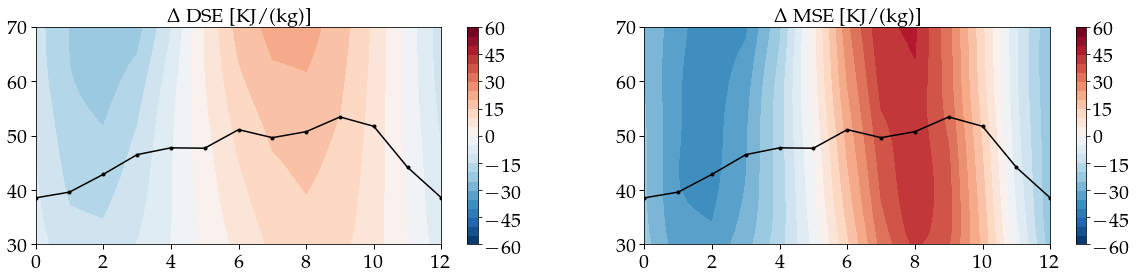

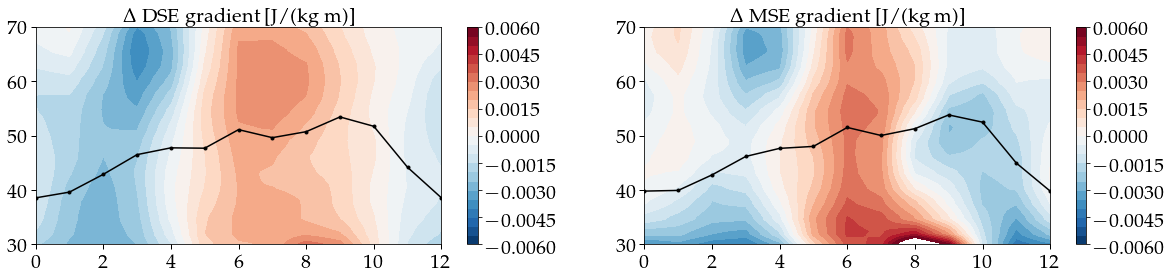

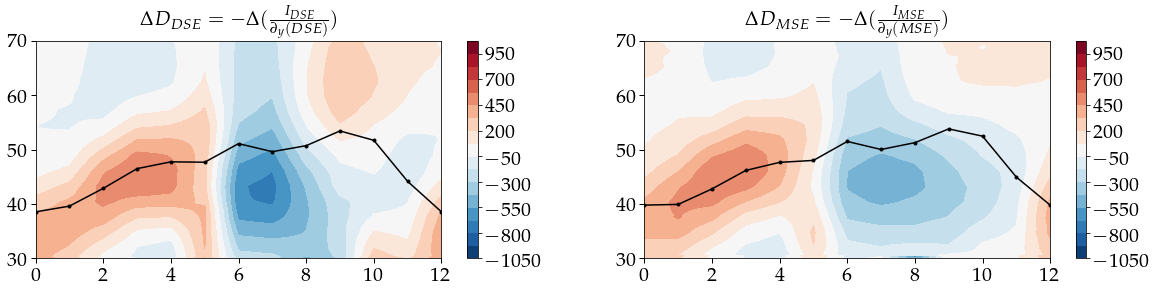

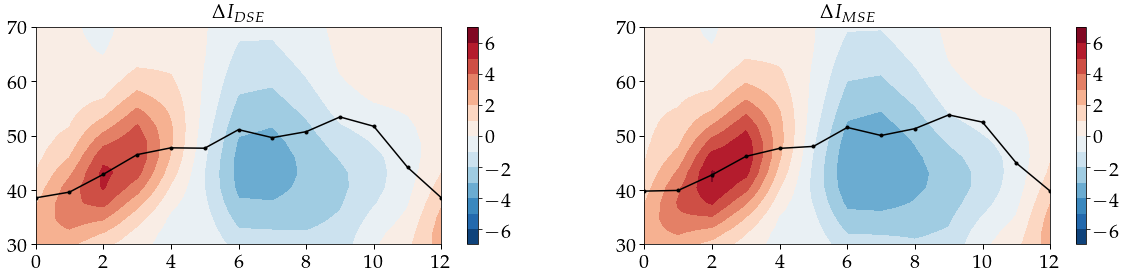

In [89]:
def spher_div_vert1(x,N=50):
       fac=1#np.cos(np.radians(lat))
       div=np.copy(x)
       for d in range(len(DEPTHS)):
        for p in range(len(sigma_full)):
          for m in range(12):
            div[d,:,p,m]= smooth(np.gradient((x[d,:,p,m])*(fac)/R,dtheta),N)
       return div
 

lev=1; d=0
DSE_gradient  = save_from_zero_error(0.00002, (div_CpT+div_gZ)[...,lev,:])
diffusive_DSE = add_month(N_S_avg1(TE_sens+TE_pot)[0])/DSE_gradient
MSE_gradient  = save_from_zero_error(0.00002, (div_CpT+div_gZ+div_Lq)[...,lev,:])
diffusive_MSE = add_month(N_S_avg1(TE_sens+TE_pot+TE_moist)[0])/MSE_gradient

DSE=(CpTv_a+gZv_a)[...,lev,:]
MSE=(CpTv_a+gZv_a+Lqv_a)[...,lev,:]
py.figure(figsize=(20,4))
py.subplot(1,2,1)
py.contourf(range(13), lat_a, prime(DSE[d,...]/1000), np.arange(-60, 65, 5),  cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos_dse[0,:], 'k.-')
py.ylim(30,70)
py.title(r"$\Delta$ DSE [KJ/(kg)]", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)

py.subplot(1,2,2)
py.contourf(range(13), lat_a, prime(MSE[d,...]/1000), np.arange(-60, 65, 5), cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos_dse[0,:], 'k.-')
py.ylim(30,70)
py.title(r"$\Delta$ MSE [KJ/(kg)]", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)


py.figure(figsize=(20,4))
delit = 0.0005
py.subplot(1,2,1)
py.contourf(range(13), lat_a, prime(DSE_gradient[d,...]), np.arange(-0.006, 0.006+delit, delit), cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos_dse[0,:], 'k.-')
py.ylim(30,70)
py.title(r"$\Delta$ DSE gradient [J/(kg m)]", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)

py.subplot(1,2,2)
py.contourf(range(13), lat_a, prime(MSE_gradient[d,...]), np.arange(-0.006, 0.006+delit, delit), cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos[0,:], 'k.-')
py.ylim(30,70)
py.title(r"$\Delta$ MSE gradient [J/(kg m)]", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)


DSE_gradient  = save_from_zero_error(0.0022, (div_CpT+div_gZ)[...,lev,:])
diffusive_DSE = add_month(N_S_avg1(TE_sens+TE_pot)[0])/DSE_gradient
MSE_gradient  = save_from_zero_error(0.0022, (div_CpT+div_gZ+div_Lq)[...,lev,:])
diffusive_MSE = add_month(N_S_avg1(TE_sens+TE_pot+TE_moist)[0])/MSE_gradient

py.figure(figsize=(20,4))
py.subplot(1,2,1)
py.contourf(range(13), lat_a, prime(-diffusive_DSE[d,...]), np.arange(-1050,1050+126,125), cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos_dse[d,:], 'k.-')
py.ylim(30,70)
py.title(r"$\Delta D_{DSE}=-\Delta (\frac{I_{DSE}}{\partial_{y}(DSE)})$", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)

py.subplot(1,2,2)
py.contourf(range(13), lat_a, prime(-diffusive_MSE[d,...]), np.arange(-1050,1050+126,125), cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos[d,:], 'k.-')
py.ylim(30,70)
py.title(r"$\Delta D_{MSE}=-\Delta (\frac{I_{MSE}}{\partial_{y}(MSE)})$", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)


py.figure(figsize=(20,4))
py.subplot(1,2,1)
py.contourf(range(13), lat_a, prime(add_month(N_S_avg1(TE_sens+TE_pot)[0])[d,...]), np.arange(-7,8,1.0), cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos_dse[d,:], 'k.-')
py.plot(-np.roll(storm_pos_dse[0,:-1],6), 'k.-')
py.ylim(30,70)
py.title(r"$\Delta I_{DSE}$", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)


py.subplot(1,2,2)
py.contourf(range(13), lat_a, prime(add_month(N_S_avg1(TE)[0])[d,...]), np.arange(-7,8,1.0),  cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.plot(storm_pos[d,:], 'k.-')
py.ylim(30,70)
py.title(r"$\Delta I_{MSE}$", fontsize=20)
py.tick_params(labelsize=20,size=5,width=1)

(30, 70)

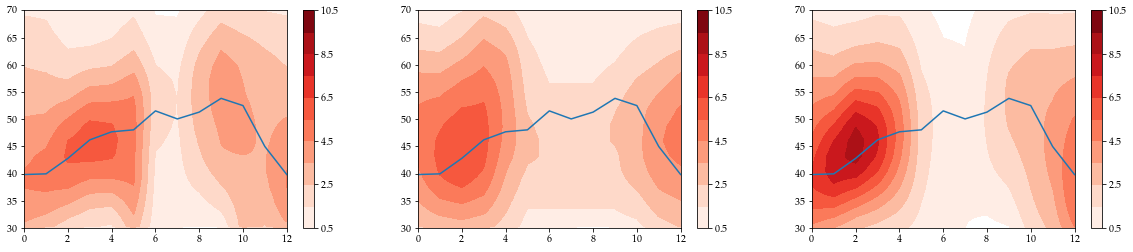

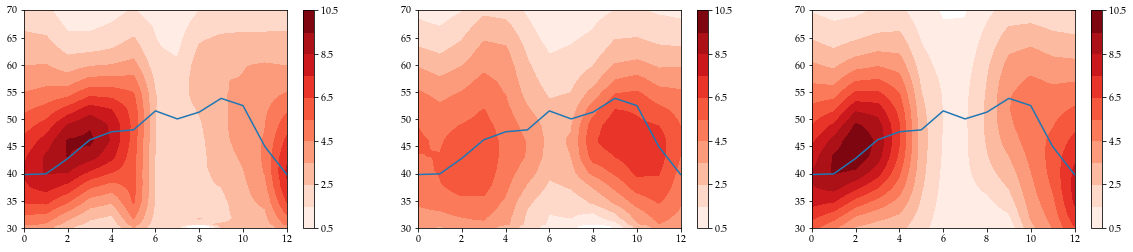

In [90]:
def Mean(X):
     return X[...,:-1].mean(axis=-1)[...,None]
def Prime(X):
    return X-mean(X)

lev=1
DSE_gradient  = save_from_zero_error(0.0022, (div_CpT+div_gZ)[...,lev,:])
diffusive_DSE = add_month(N_S_avg1(TE_sens+TE_pot)[0])/DSE_gradient
MSE_gradient  = save_from_zero_error(0.0022, (div_CpT+div_gZ+div_Lq)[...,lev,:])
diffusive_MSE = add_month(N_S_avg1(TE_sens+TE_pot+TE_moist)[0])/MSE_gradient

D_Gmean= (diffusive_DSE)*Mean(DSE_gradient)
Dmean_G= Mean(diffusive_DSE)*(DSE_gradient)

py.figure(figsize=(20,4))
py.subplot(1,3,1)
py.contourf(range(13), lat_a, (D_Gmean)[0,...], np.arange(0.5,11.5,1.0),  cmap=cm.Reds); py.colorbar()
py.plot(storm_pos[0,:]); py.ylim(30,70)
py.subplot(1,3,2)
py.contourf(range(13), lat_a, (Dmean_G)[0,...], np.arange(0.5,11.5,1.0),  cmap=cm.Reds); py.colorbar()
py.plot(storm_pos[0,:]); py.ylim(30,70)
py.subplot(1,3,3)
py.contourf(range(13), lat_a, (N_S_avg1(add_month(TE_sens+TE_pot))[0])[0,...],  np.arange(0.5,11.5,1.0),  cmap=cm.Reds); py.colorbar()
py.plot(storm_pos[0,:]); py.ylim(30,70)

def Mean(X):
     return X[...,:-1].mean(axis=-1)[...,None]
def Prime(X):
    return X-mean(X)

D_Gmean= (diffusive_MSE)*Mean(MSE_gradient)
Dmean_G= Mean(diffusive_MSE)*(MSE_gradient)

py.figure(figsize=(20,4))
py.subplot(1,3,1)
py.contourf(range(13), lat_a, (D_Gmean)[0,...], np.arange(0.5,11.5,1.0),  cmap=cm.Reds); py.colorbar()
py.plot(storm_pos[0,:]); py.ylim(30,70)
py.subplot(1,3,2)
py.contourf(range(13), lat_a, (Dmean_G)[0,...], np.arange(0.5,11.5,1.0), cmap=cm.Reds); py.colorbar()
py.plot(storm_pos[0,:]); py.ylim(30,70)
py.subplot(1,3,3)
py.contourf(range(13), lat_a, (N_S_avg1(add_month(TE_sens+TE_pot+TE_moist))[0])[0,...],  np.arange(0.5,11.5,1.0),  cmap=cm.Reds); py.colorbar()
py.plot(storm_pos[0,:]); py.ylim(30,70)

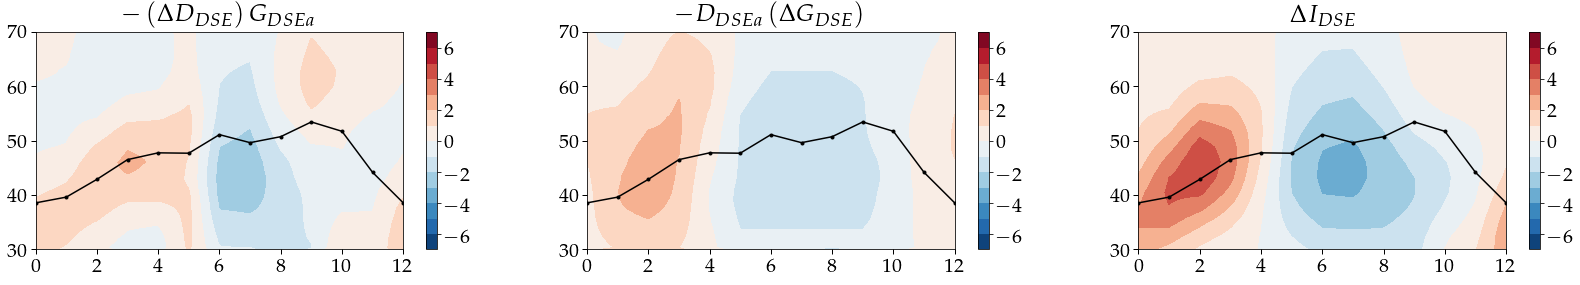

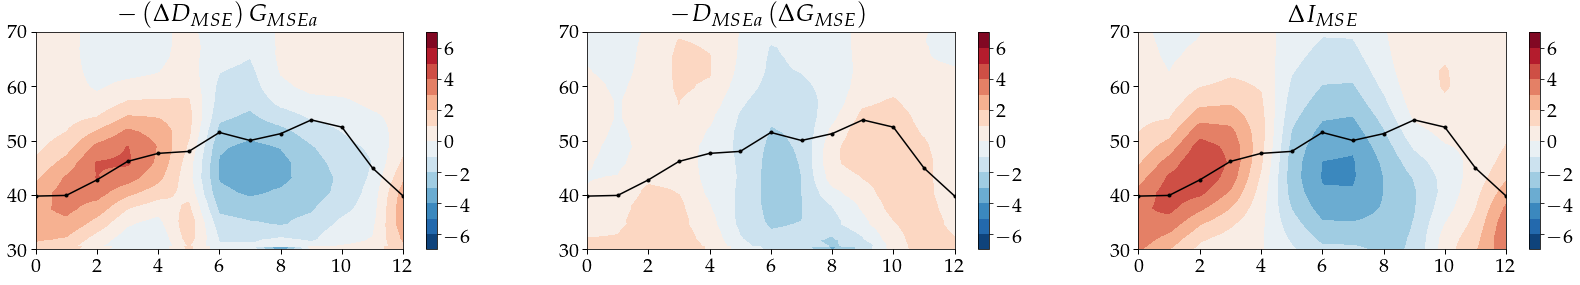

In [91]:
def Mean(X):
     return X[...,:-1].mean(axis=-1)[...,None]
def Prime(X):
    return X-mean(X)

lev=1; d=0
DSE_gradient  = save_from_zero_error(0.0022, (div_CpT+div_gZ)[...,lev,:])
diffusive_DSE = add_month(N_S_avg1(TE_sens+TE_pot)[0])/DSE_gradient
MSE_gradient  = save_from_zero_error(0.0022, (div_CpT+div_gZ+div_Lq)[...,lev,:])
diffusive_MSE = add_month(N_S_avg1(TE_sens+TE_pot+TE_moist)[0])/MSE_gradient

D_Gmean= (diffusive_DSE)*Mean(DSE_gradient)
Dmean_G= Mean(diffusive_DSE)*(DSE_gradient)

py.figure(figsize=(28,4))
py.subplot(1,3,1)
py.contourf(range(13), lat_a, prime(D_Gmean)[0,...], np.arange(-7,8,1.0),  cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.title(r"$-\left(\Delta D_{DSE}\right)G_{DSEa}$", fontsize=25)
py.plot(storm_pos_dse[d,:], 'k.-'); py.ylim(30,70)
py.tick_params(labelsize=20,size=5,width=1)
py.subplot(1,3,2)
py.contourf(range(13), lat_a, prime(Dmean_G)[0,...], np.arange(-7,8,1.0),  cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.title(r"$-D_{DSEa}\left(\Delta G_{DSE}\right)$", fontsize=25)
py.plot(storm_pos_dse[d,:], 'k.-'); py.ylim(30,70)
py.tick_params(labelsize=20,size=5,width=1)
py.subplot(1,3,3)
py.contourf(range(13), lat_a, prime(N_S_avg1(add_month(TE_sens+TE_pot))[0])[0,...],  np.arange(-7,8,1.0),  cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.title(r"$\Delta I_{DSE}$", fontsize=25)
py.plot(storm_pos_dse[d,:], 'k.-'); py.ylim(30,70)
py.tick_params(labelsize=20,size=5,width=1)

def Mean(X):
     return X[...,:-1].mean(axis=-1)[...,None]
def Prime(X):
    return X-mean(X)

D_Gmean= (diffusive_MSE)*Mean(MSE_gradient)
Dmean_G= Mean(diffusive_MSE)*(MSE_gradient)

py.figure(figsize=(28,4))
py.subplot(1,3,1)
py.contourf(range(13), lat_a, prime(D_Gmean)[0,...], np.arange(-7,8,1.0),  cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.title(r"$-\left(\Delta D_{MSE}\right)G_{MSEa}$", fontsize=25)
py.plot(storm_pos[d,:], 'k.-'); py.ylim(30,70)
py.tick_params(labelsize=20,size=5,width=1)
py.subplot(1,3,2)
py.contourf(range(13), lat_a, prime(Dmean_G)[0,...], np.arange(-7,8,1.0),  cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.title(r"$-D_{MSEa}\left(\Delta G_{MSE}\right)$", fontsize=25)
py.plot(storm_pos[d,:], 'k.-'); py.ylim(30,70)
py.tick_params(labelsize=20,size=5,width=1)
py.subplot(1,3,3)
py.contourf(range(13), lat_a, prime(N_S_avg1(add_month(TE_sens+TE_pot+TE_moist))[0])[0,...],  np.arange(-7,8,1.0),  cmap=cm.RdBu_r); cbar=py.colorbar()
cbar.ax.tick_params(labelsize=20) 
py.title(r"$\Delta I_{MSE}$", fontsize=25)
py.plot(storm_pos[d,:], 'k.-'); py.ylim(30,70)
py.tick_params(labelsize=20,size=5,width=1)


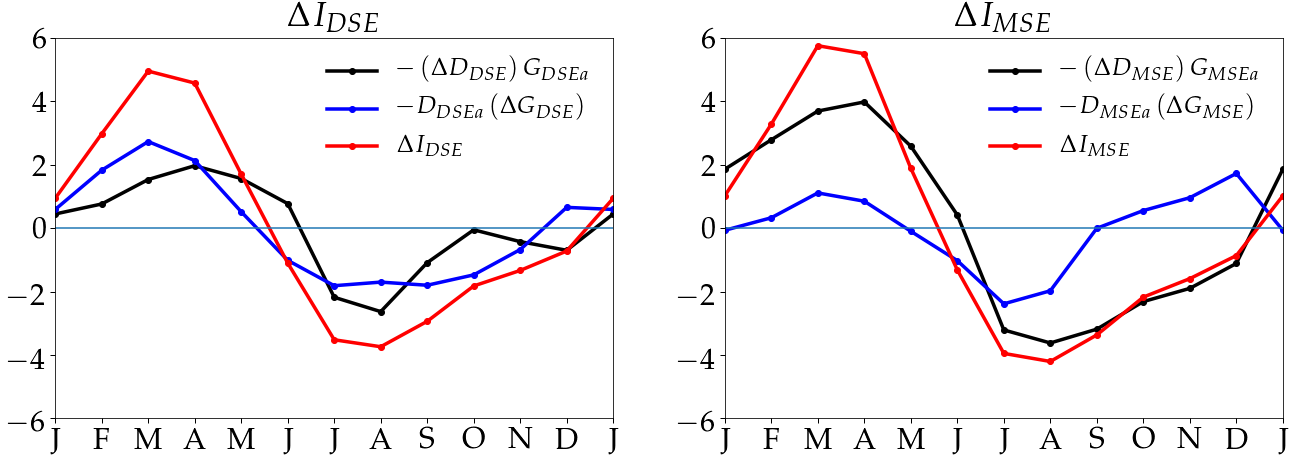

In [92]:
d=0;
mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

DSE_gradient  = save_from_zero_error(0.0022, (div_CpT+div_gZ)[...,lev,:])
diffusive_DSE = add_month(N_S_avg1(TE_sens+TE_pot)[0])/DSE_gradient
MSE_gradient  = save_from_zero_error(0.0022, (div_CpT+div_gZ+div_Lq)[...,lev,:])
diffusive_MSE = add_month(N_S_avg1(TE_sens+TE_pot+TE_moist)[0])/MSE_gradient

py.figure(figsize=(22,7))

py.subplot(1,2,1)

DeltaD_Gmean= ((diffusive_DSE)*Mean(DSE_gradient))
Dmean_DeltaG= (Mean(diffusive_DSE)*(DSE_gradient))

D_Gmean_a = inerp_at_max((DeltaD_Gmean), lat_a)
Dmean_G_a = inerp_at_max((Dmean_DeltaG), lat_a)
DG_a      = inerp_at_max(add_month(N_S_avg1(TE_sens+TE_pot)[0]), lat_a)

py.plot(range(13), prime(D_Gmean_a)[d,:], 'ko-', lw=3.5, label=r"$-\left(\Delta D_{DSE}\right)G_{DSEa}$")
py.plot(range(13), prime(Dmean_G_a)[d,:], 'bo-', lw=3.5, label=r"$-D_{DSEa}\left(\Delta G_{DSE}\right)$")
py.plot(range(13), prime(DG_a)[d,:],      'ro-', lw=3.5, label=r"$\Delta I_{DSE}$")
py.tick_params(labelsize=30,size=5,width=1)
py.xticks(range(13), mticks,size=37)
py.tick_params(labelsize=30,size=5,width=1)
py.legend(loc='best',fontsize=25,ncol=1,frameon=False)
py.ylim(-6,6)
py.xlim(0,12)
py.axhline(0)
py.title(r"$\Delta I_{DSE}$", fontsize=35)

py.subplot(1,2,2)

DeltaD_Gmean= ((diffusive_MSE)*Mean(MSE_gradient))
Dmean_DeltaG= (Mean(diffusive_MSE)*(MSE_gradient))

D_Gmean_a = inerp_at_max((DeltaD_Gmean), lat_a)
Dmean_G_a = inerp_at_max((Dmean_DeltaG), lat_a)
DG_a      = inerp_at_max(add_month(N_S_avg1(TE)[0]), lat_a)

py.plot(range(13), prime(D_Gmean_a)[d,:], 'ko-', lw=3.5, label=r"$-\left(\Delta D_{MSE}\right)G_{MSEa}$")
py.plot(range(13), prime(Dmean_G_a)[d,:], 'bo-',lw=3.5, label=r"$-D_{MSEa}\left(\Delta G_{MSE}\right)$")
py.plot(range(13), prime(DG_a)[d,:],      'ro-',lw=3.5, label=r"$\Delta I_{MSE}$")
py.tick_params(labelsize=30,size=5,width=1)
py.xticks(range(13), mticks,size=37)
py.tick_params(labelsize=30,size=5,width=1)
py.legend(loc='best',fontsize=25,ncol=1,frameon=False)
py.ylim(-6,6)
py.xlim(0,12)
py.axhline(0)
py.title(r"$\Delta I_{MSE}$", fontsize=35)



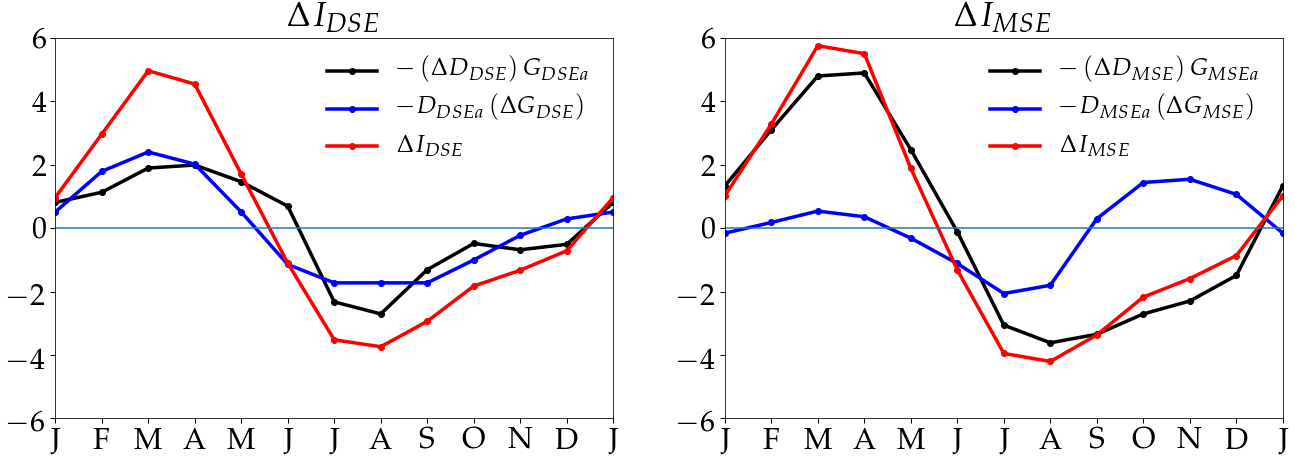

In [93]:
d=0;
mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']

DSE_gradient  = save_from_zero_error(0.0022, (div_CpT+div_gZ)[...,lev,:])
IDSE          = add_month(N_S_avg1(TE_sens+TE_pot)[0])
diffusive_DSE = -IDSE/DSE_gradient

MSE_gradient  = save_from_zero_error(0.0022, (div_CpT+div_gZ+div_Lq)[...,lev,:])
IMSE         =  TE_a
diffusive_MSE = -IMSE/MSE_gradient


py.figure(figsize=(22,7))

py.subplot(1,2,1)

G_a = inerp_at_max(DSE_gradient,lat_a,storm_pos_dse)
I_a = inerp_at_max(IDSE,lat_a,storm_pos_dse)
D_a = inerp_at_max(diffusive_DSE,lat_a,storm_pos_dse)

DGa  = -prime(D_a)*mean(G_a)
DaG  = -mean(D_a)*prime(G_a)
DG   = prime(I_a)
DG1  = -prime(D_a)*prime(G_a)

py.plot(range(13), (DGa)[d,:], 'ko-', lw=3.5, label=r"$-\left(\Delta D_{DSE}\right)G_{DSEa}$")
py.plot(range(13), (DaG)[d,:], 'bo-', lw=3.5, label=r"$-D_{DSEa}\left(\Delta G_{DSE}\right)$")
py.plot(range(13), (DG)[d,:],      'ro-', lw=3.5, label=r"$\Delta I_{DSE}$")
# py.plot(range(13), prime(DG1)[d,:],      'ro--', lw=3.5, label=r"$\Delta I_{DSE} approx$")
py.tick_params(labelsize=30,size=5,width=1)
py.xticks(range(13), mticks,size=37)
py.tick_params(labelsize=30,size=5,width=1)
py.legend(loc='best',fontsize=25,ncol=1,frameon=False)
py.ylim(-6,6)
py.xlim(0,12)
py.axhline(0)
py.title(r"$\Delta I_{DSE}$", fontsize=35)

py.subplot(1,2,2)

G_a = inerp_at_max(MSE_gradient,lat_a,storm_pos)
I_a = inerp_at_max(IMSE,lat_a,storm_pos)
D_a = inerp_at_max(diffusive_MSE,lat_a,storm_pos)

DGa  = -prime(D_a)*mean(G_a)
DaG  = -mean(D_a)*prime(G_a)
DG   = prime(I_a)
DG1  = -prime(D_a)*prime(G_a)

py.plot(range(13), (DGa)[d,:], 'ko-', lw=3.5, label=r"$-\left(\Delta D_{MSE}\right)G_{MSEa}$")
py.plot(range(13), (DaG)[d,:], 'bo-', lw=3.5, label=r"$-D_{MSEa}\left(\Delta G_{MSE}\right)$")
py.plot(range(13), (DG)[d,:],      'ro-', lw=3.5, label=r"$\Delta I_{MSE}$")
# py.plot(range(13), prime(DG1)[d,:],      'mo--', lw=3.5, label=r"$\Delta I_{MSE} approx$")
py.tick_params(labelsize=30,size=5,width=1)
py.xticks(range(13), mticks,size=37)
py.tick_params(labelsize=30,size=5,width=1)
py.legend(loc='best',fontsize=25,ncol=1,frameon=False)
py.ylim(-6,6)
py.xlim(0,12)
py.axhline(0)
py.title(r"$\Delta I_{MSE}$", fontsize=35)

In [94]:
def plot_at_storm_position(d,l,month_to_month=1,f='T'):
    py.rc('font', family='serif', serif='Palatino',weight='normal')
    
    DEPTHS_title=["5m","50m"]     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
#     def D(y,d):
#         return y[d,...]
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        
    if f=='T':
            py.plot(D(i3_a,d),'ko-',label=I3T,lw=3.5)
            py.plot(D(i4_a,d),'bo-',label=I4T,lw=3.5)
    else :
#             py.plot(D(i3_a,d),'ko-',label=I3,lw=3.5)
            py.plot(D(imain_a-i4_a,d),'ko-',label=I3,lw=3.5)
            py.plot(D(i4_a,d),'bo-',label=I4,lw=3.5)
            
#     I3=r'$-(\Delta D) {G_{a}}$'
#     I4=r'$-{D_{a}} (\Delta G)$'
      
    py.plot(D(imain_a,d),'ro-',label=r'$\Delta I$',lw=3.5) 
                                             
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title=""+" "+" "+str(depth)+"m"
    py.title(str(DEPTHS_title[d]),fontsize=35,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.legend(loc='best',fontsize=20,ncol=2,frameon=False)
    py.tight_layout()

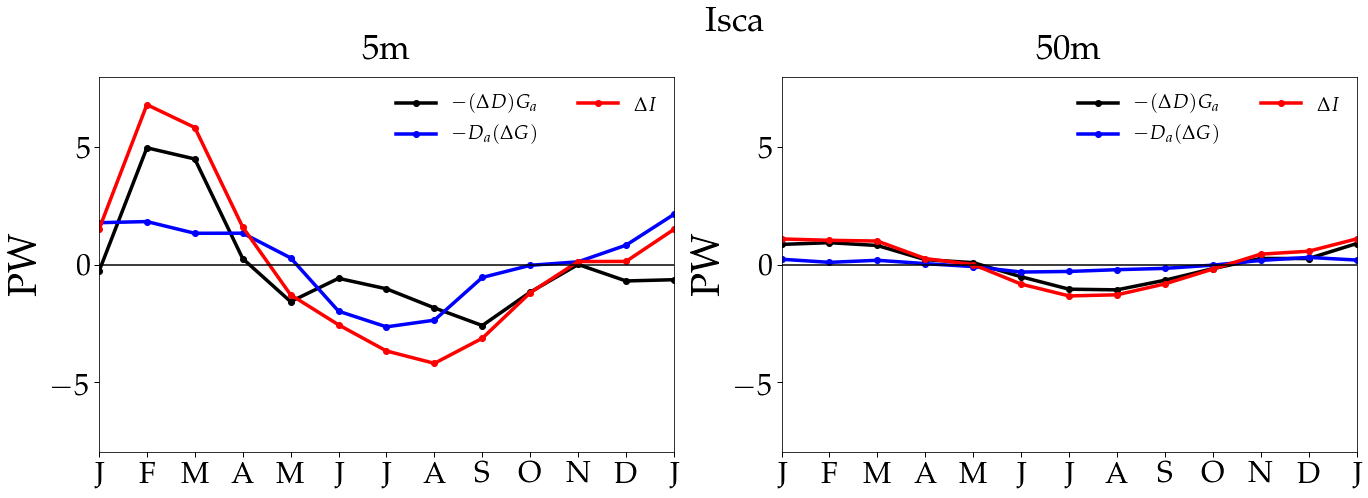

In [95]:
def N_S_avg1(field, lat=lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90)) 
    l_S=((lat>=-90) & (lat<=0))
    

    avg = lambda x: (x[:,l_N,...]+flux_flag*np.roll(x[:,l_S,...][:,::-1,...], int(field.shape[-1]/2), axis=-1))/2.0  
    lat_a = lat[l_N]
        
    field1= avg(field)    
    
    return (field1), lat_a
    

dm_by_dphi_a, lat_a     = N_S_avg1(divMSE_all[...,level,:])
dm_by_dphi_a[ ((dm_by_dphi_a<0.002) & (dm_by_dphi_a>-0.002))]=0.002
# dm_by_dphi_a            = save_from_zero_error(0.004,dm_by_dphi_a)
# dm_by_dphi_a,lat_a      = (dm_by_dphi,lat)


diffusivity_sfc       = smooth_multi(-(TE_a+SE_a+MM_a)/dm_by_dphi_a,200, smoothing=0)
# diffusivity_sfc       = smooth_multi(-(TE_a+SE_a+MM_a)/dm_by_dphi_a,200)


def mean(X):
     return X[...,:-1].mean(axis=-1)[...,None]
def prime(X):
    return X-mean(X)


D_mean =mean(diffusivity_sfc)
Im_mean=mean(dm_by_dphi_a)
I_mean =mean(TE_a+SE_a+MM_a)

D_prime =prime(diffusivity_sfc)
Im_prime=prime(dm_by_dphi_a)
I_prime =prime(TE_a+SE_a+MM_a)

D_Gmean= -1*diffusivity_sfc*Im_mean
Dmean_G= -1*D_mean*dm_by_dphi_a
DG     =  TE_a+SE_a+MM_a

from scipy import interpolate
def interp(x,xnew, y,ax=1):
    f = interpolate.interp1d(x, y, fill_value='extrapolate', axis=ax)
    ynew = f(xnew)  
    return ynew

def find_maxima(y,lat_a):
   maxx=np.zeros((y.shape[0],y.shape[-1])); loc=np.copy(maxx); ind=np.copy(maxx)
   for d in range(y.shape[0]): 
     for m in range(y.shape[-1]):
        maxx[d,m] =  np.max(y[d,:,m])
        loc[d,m] = interp(x=y[d,:,m], xnew=maxx[d,m], y=lat_a, ax=0)
   return maxx, loc


i3_a   =find_maxima(D_Gmean,lat_a)[0]
i4_a   =find_maxima(Dmean_G,lat_a)[0]

imain_a = find_maxima(DG,lat_a)[0]

#i_a       =inerp_at_max(i_sum,lat_a)
# teprime_a=inerp_at_max(TE_prime,lat_a)

l=8.0; i=0;
fig=py.figure(figsize=(38, 12))
for d in range(len(DEPTHS)):
    py.subplot(2,4,i+1)
    plot_at_storm_position(d,l,0,f="F")
    i=i+1
    py.rc('font', family='serif', serif='Palatino',weight='normal')
    py.tight_layout()
py.suptitle("Isca", fontsize=35, x=0.27, y=1.02)

## Same as above but with vertically averaged dm/dphi

In [80]:
so='/project2/tas1/pragallva/Winter_quarter_2019/codes/python_scripts/miscellaneous/Paper_figures_ISCA/'
pressure_info=load(so+"pressure.hkl")
weights=pressure_info["weights"]
pressure=pressure_info["pressure"][:,:,::-1,:]
psfc=pressure_info["psfc"]

weights_a, pressure_a, weights_a, weights_a, weights_a, lat_a = N_S_avg(weights, pressure, weights, weights, weights, lat, flux_flag=1)

def add_month(y):
    y1 = np.append(y,y[...,None,0],axis=-1)
    return y1

def vert_int(y, pi=2, pf=-10):
    integral = (y*weights_a)[...,pi:pf,:].sum(axis=-2)
    average  = (y*weights_a)[...,pi:pf,:].mean(axis=-2)/(weights_a)[...,pi:pf,:].mean(axis=-2)
    return integral, average

def vert_int1(y, pi=0, pf=-10):
    integral = (y*weights)[...,pi:pf,:].sum(axis=-2)
    average  = (y*weights)[...,pi:pf,:].sum(axis=-2)/(weights)[...,pi:pf,:].sum(axis=-2)
    return integral, average


In [97]:
qv  = vert_int1(q)[1]
RHv = qv/qsat
# save('/project2/tas1/pragallva/climlab/RHv.hkl',RHv)

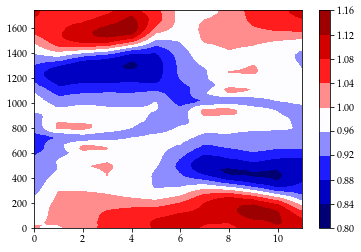

In [98]:
py.contourf(RH[0,...],cmap=cm.seismic); py.colorbar()

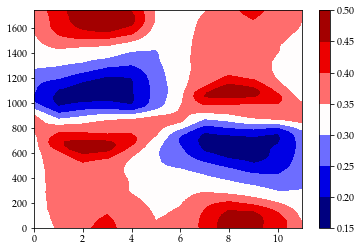

In [99]:
py.contourf(RHv[0,...],cmap=cm.seismic); py.colorbar()

In [100]:
def plot_new_at_storm_position(d,l,month_to_month=1,f='F'):
   
    DEPTHS_title=["5m","50m"]     
    py.rc('text', usetex=True)
#     py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    
    if f=='T':
        py.plot(D(te_const_div_a,d),'ko-',label=I3vT,lw=3.5)
        py.plot(D(te_const_D_a  ,d),'bo-',label=I4vT,lw=3.5)
        py.plot(D(te_a,          d),'ro-',label=r'$\Delta I$',lw=3.5) 
    else :
        py.plot(D(te_const_div_a,d),'ko-',label=I3v,lw=3.5)
        py.plot(D(te_const_D_a  ,d),'bo-',label=I4v,lw=3.5)
        py.plot(D(te_a,          d),'ro-',label=r'$\Delta I$',lw=3.5) 
                                             
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title=""+" "+" "+str(depth)+"m"
    py.title(str(DEPTHS_title[d]),fontsize=35,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.legend(loc='best',fontsize=20,ncol=2,frameon=False)
    py.tight_layout()

/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide


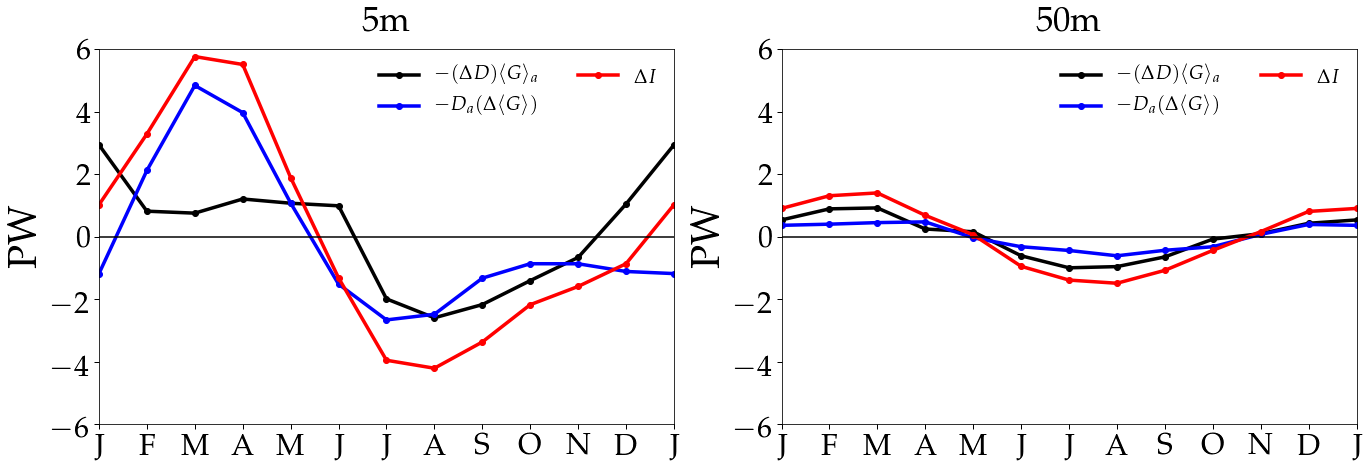

In [101]:
level=1
dm_by_dphi_v         = vert_int(masked_div_MSE)[1]
not_mask_of_TE_a     = ma.masked_less(TE_a, threshold)  ### Positive transient eddies
masked_TE_a          = ma.masked_where( ma.getmask(not_mask_of_TE_a), TE_a)
diffusivity_v        = -TE_a/dm_by_dphi_v


def mean(X):
     return X[...,:-1].mean(axis=-1)[...,None]
def prime(X):
    return X-mean(X)


D_mean =mean(diffusivity_v)
Im_mean=mean(dm_by_dphi_v)
I_mean =mean(TE_a)

D_prime =prime(diffusivity_v)
Im_prime=prime(dm_by_dphi_v)
I_prime =prime(TE_a)

te           = -diffusivity_v*dm_by_dphi_v
te_const_D   = -mean(diffusivity_v)*dm_by_dphi_v
te_const_div = -(diffusivity_v)*mean(dm_by_dphi_v)

te_a           = inerp_at_max(te,lat_a)
te_const_D_a   = inerp_at_max(te_const_D,lat_a)
te_const_div_a = inerp_at_max(te_const_div,lat_a)

l=6.0; i=0;
fig=py.figure(figsize=(38, 12))
for d in range(len(DEPTHS)):
    py.subplot(2,4,i+1)
    plot_new_at_storm_position(d,l,0)
    i=i+1
    py.tight_layout()


/home/pragallva/Project1/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in divide


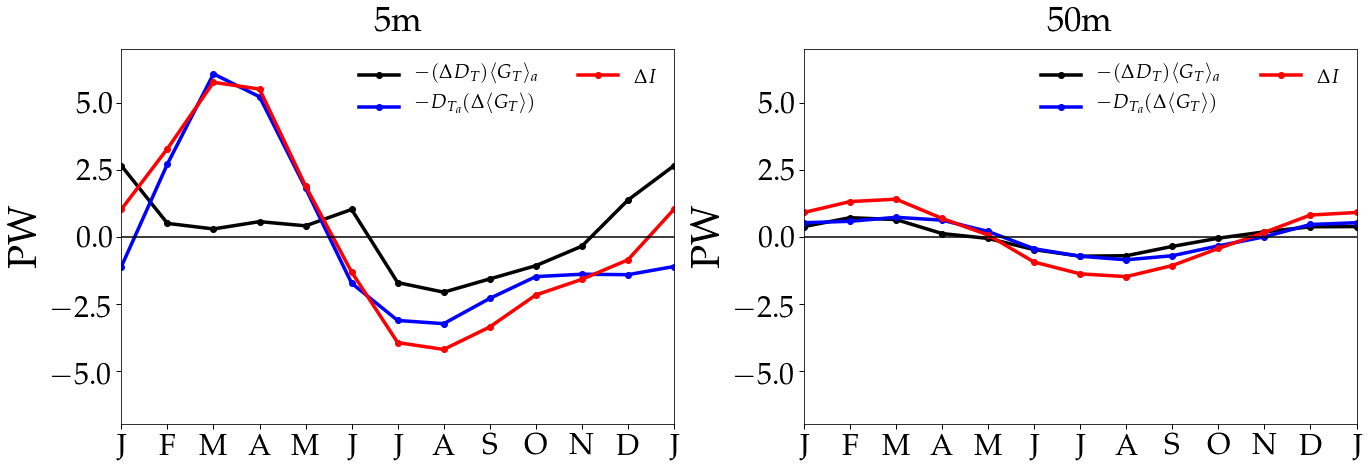

In [102]:
level=1
dCpT_by_dphi_v       = vert_int(masked_div_CpT)[1]
not_mask_of_TE_a     = ma.masked_less(TE_a, threshold)  ### Positive transient eddies
masked_TE_a          = ma.masked_where( ma.getmask(not_mask_of_TE_a), TE_a)
diffusivity_v        = -TE_a/dCpT_by_dphi_v

def mean(X):
     return X[...,:-1].mean(axis=-1)[...,None]
def prime(X):
    return X-mean(X)


D_mean =mean(diffusivity_v)
Im_mean=mean(dCpT_by_dphi_v)
I_mean =mean(TE_a)

D_prime =prime(diffusivity_v)
Im_prime=prime(dCpT_by_dphi_v)
I_prime =prime(TE_a)

te           = -diffusivity_v*dCpT_by_dphi_v
te_const_D   = -mean(diffusivity_v)*dCpT_by_dphi_v
te_const_div = -(diffusivity_v)*mean(dCpT_by_dphi_v)

te_a           = inerp_at_max(te,lat_a)
te_const_D_a   = inerp_at_max(te_const_D,lat_a)
te_const_div_a = inerp_at_max(te_const_div,lat_a)

l=6.0; i=0;
fig=py.figure(figsize=(38, 12))
for d in range(len(DEPTHS)):
    py.subplot(2,4,i+1)
    plot_new_at_storm_position(d,l,0,f='T')
    i=i+1
    py.ylim(-7,7)
    py.tight_layout()


In [103]:
def plot_at_storm_position(d,l,month_to_month=1,f='T'):
    py.rc('font', family='serif', serif='Palatino',weight='normal')
    
    DEPTHS_title=["5m","50m"]     
    py.rc('text', usetex=True)
    py.rc('font', family='serif', serif='Palatino',weight='bold')
    
    mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
    def D(y,d):
        if month_to_month==1 :
            y1=y#np.append(y,y[:,0,np.newaxis],axis=1)
            x1=y1[d,1:]-y1[d,:-1]
            x2=np.append(x1[-1],x1)
            mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
        else :
            y1=y[d,:]-y[d,:-1,None].mean(axis=0)
            x2=y1
            mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        return x2
#     def D(y,d):
#         return y[d,...]
    
    if month_to_month==1 :
        mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    else :
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        
    if f=='T':
            py.plot(D(i3_a,d),'ko-',label=I3vT,lw=3.5)
            py.plot(D(i4_a,d),'bo-',label=I4vT,lw=3.5)
    else :
#             py.plot(D(i3_a,d),'ko-',label=I3,lw=3.5)
            py.plot(D(imain_a-i4_a,d),'ko-',label=I3v,lw=3.5)
            py.plot(D(i4_a,d),'bo-',label=I4v,lw=3.5)
            
#     I3=r'$-(\Delta D) {G_{a}}$'
#     I4=r'$-{D_{a}} (\Delta G)$'
      
    py.plot(D(imain_a,d),'ro-',label=r'$\Delta I$',lw=3.5) 
                                             
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    py.ylabel("PW", fontsize=40)
    title=""+" "+" "+str(depth)+"m"
    py.title(str(DEPTHS_title[d]),fontsize=35,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)
    py.legend(loc='best',fontsize=20,ncol=2,frameon=False)
    py.tight_layout()

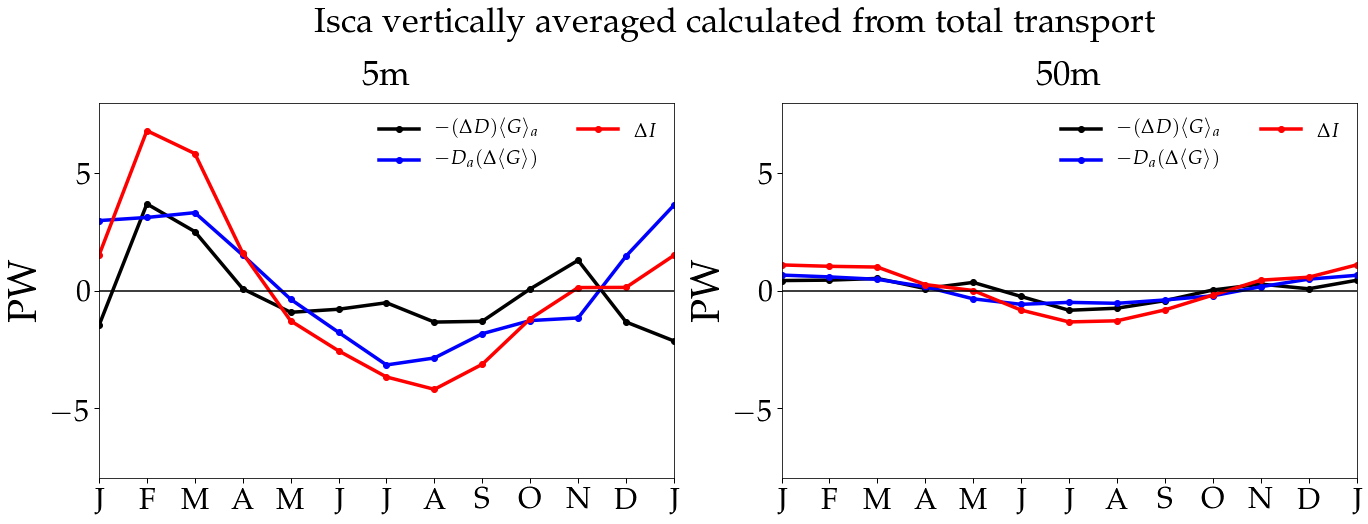

In [104]:
def N_S_avg1(field, lat=lat, flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90)) 
    l_S=((lat>=-90) & (lat<=0))
    

    avg = lambda x: (x[:,l_N,...]+flux_flag*np.roll(x[:,l_S,...][:,::-1,...], int(field.shape[-1]/2), axis=-1))/2.0  
    lat_a = lat[l_N]
        
    field1= avg(field)    
    
    return (field1), lat_a




dm_by_dphi_a      = vert_int(N_S_avg1(divMSE_all)[0], pi=0, pf=-1)[1]
dm_by_dphi_a[ ((dm_by_dphi_a<0.002) & (dm_by_dphi_a>-0.002))]=0.002
# dm_by_dphi_a            = save_from_zero_error(0.004,dm_by_dphi_a)
# dm_by_dphi_a,lat_a      = (dm_by_dphi,lat)

diffusivity_sfc       = smooth_multi(-(TE_a+SE_a+MM_a)/dm_by_dphi_a,200, smoothing=0)
# diffusivity_sfc       = smooth_multi(-(TE_a+SE_a+MM_a)/dm_by_dphi_a,200)


def mean(X):
     return X[...,:-1].mean(axis=-1)[...,None]
def prime(X):
    return X-mean(X)


D_mean =mean(diffusivity_sfc)
Im_mean=mean(dm_by_dphi_a)
I_mean =mean(TE_a+SE_a+MM_a)

D_prime =prime(diffusivity_sfc)
Im_prime=prime(dm_by_dphi_a)
I_prime =prime(TE_a+SE_a+MM_a)

D_Gmean= -1*diffusivity_sfc*Im_mean
Dmean_G= -1*D_mean*dm_by_dphi_a
DG     =  -(dm_by_dphi_a)*diffusivity_sfc#*#TE_a+SE_a+MM_a

from scipy import interpolate
def interp(x,xnew, y,ax=1):
    f = interpolate.interp1d(x, y, fill_value='extrapolate', axis=ax)
    ynew = f(xnew)  
    return ynew

def find_maxima(y,lat_a):
   maxx=np.zeros((y.shape[0],y.shape[-1])); loc=np.copy(maxx); ind=np.copy(maxx)
   for d in range(y.shape[0]): 
     for m in range(y.shape[-1]):
        maxx[d,m] =  np.max(y[d,:,m])
        loc[d,m] = interp(x=y[d,:,m], xnew=maxx[d,m], y=lat_a, ax=0)
   return maxx, loc


i3_a   =find_maxima(D_Gmean,lat_a)[0]
i4_a   =find_maxima(Dmean_G,lat_a)[0]

imain_a = find_maxima(DG,lat_a)[0]

#i_a       =inerp_at_max(i_sum,lat_a)
# teprime_a=inerp_at_max(TE_prime,lat_a)

l=8.0; i=0;
fig=py.figure(figsize=(38, 12))
for d in range(len(DEPTHS)):
    py.subplot(2,4,i+1)
    plot_at_storm_position(d,l,0,f="F")
    i=i+1
    py.rc('font', family='serif', serif='Palatino',weight='normal')
    py.tight_layout()
py.suptitle("Isca vertically averaged calculated from total transport", fontsize=35, x=0.27, y=1.05)

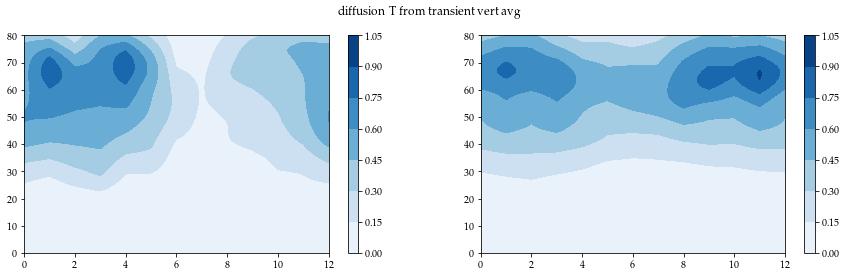

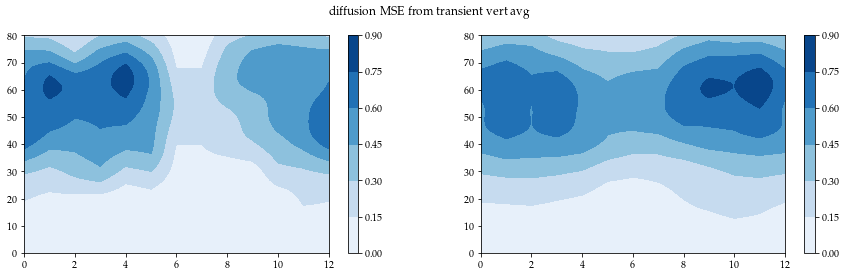

In [105]:
import numpy.ma as ma

level=1

def add_month(y):
    return np.append(y,y[...,0,None],axis=-1)

def save_from_zero_error(threshold,y):
    ind=(np.where((y<threshold) & (y>0)))
    y[ind]=threshold
    ind=(np.where((y>-1*threshold) & (y<0)))
    y[ind]=-1*threshold
    return y

def remove_negative(threshold,y):
    ind=(np.where((y<threshold)))
    y[ind]=threshold
    return y

def smooth_multi(y, box_pts,smoothing=1,ax=1):
    box = np.ones(box_pts)/box_pts
    y_smooth=np.apply_along_axis(np.convolve, ax, y, box, mode='same')
    if smoothing == 1 :
        return y_smooth
    else :
        return y
    
def vert_int1(y, pi=2, pf=-10):
    integral = (y*add_month(weights))[...,pi:pf,:].sum(axis=-2)
    average  = (y*add_month(weights))[...,pi:pf,:].mean(axis=-2)/(add_month(weights))[...,pi:pf,:].mean(axis=-2)
    return integral, average


Tv         = add_month(T)
divT       = spher_div_vert(Tv)
divMSE_all = spher_div_vert(add_month(Cp*T+g*Z+L*q))

import numpy.ma as ma

threshold               = 0.0001

dm_by_dphi              = vert_int1(divMSE_all)[1]
dm_by_dphi              = save_from_zero_error(0.004,dm_by_dphi)
dT_by_dphi              = vert_int1(divT)[1]
dT_by_dphi              = save_from_zero_error(0.000002,dT_by_dphi)

diffus_sfc_mse          = -add_month(TE)*10**15/(2*np.pi*a**3*np.cos(np.deg2rad(lat[None,:,None]))*dm_by_dphi)
diffus_sfc_mse          = remove_negative(0.00001,smooth_multi(diffus_sfc_mse,100))
diffus_sfc_T            = -add_month(TE_sens)*10**15/(2*np.pi*a**3*np.cos(np.deg2rad(lat[None,:,None]))*dT_by_dphi)
diffus_sfc_T            = remove_negative(0.0001,smooth_multi(diffus_sfc_T,100))

diffusion_data = {
    "lat"            : lat,
    "divT"           : divT,
    "T"              : Tv,
    "MSE"            : add_month(Cp*T+g*Z+L*q),
    "dm_by_dphi"     : dm_by_dphi,
    "dT_by_dphi"     : dT_by_dphi,
    "diffus_sfc_mse" : diffus_sfc_mse,
    "diffus_sfc_T"   : diffus_sfc_T,
    "heat_flux_PW"   : add_month(TE_sens),
    "heat_flux_Wm-1" : add_month(TE_sens)*10**15/(2*np.pi*a*np.cos(np.deg2rad(lat[None,:,None]))),  
    "MSE_flux_PW"    : add_month(TE),
    "MSE_flux_Wm-1"  : add_month(TE)*10**15/(2*np.pi*a*np.cos(np.deg2rad(lat[None,:,None]))),   
}

# make_sure_path_exists("/project2/tas1/pragallva/climlab/data/")
# save("/project2/tas1/pragallva/climlab/data/diffusion_data_from_transient_vert_avg.hkl", diffusion_data)

py.figure(figsize=(15,4))
py.subplot(1,2,1)
py.ylim(0,80)
py.contourf(range(13), lat, diffus_sfc_T[0,...], cmap= cm.Blues ); py.colorbar()
py.subplot(1,2,2)
py.contourf(range(13), lat, diffus_sfc_T[1,...], cmap= cm.Blues ); py.colorbar()
py.ylim(0,80)
py.suptitle("diffusion T from transient vert avg")

py.figure(figsize=(15,4))
py.subplot(1,2,1)
py.ylim(0,80)
py.contourf(range(13), lat, Cp*diffus_sfc_mse[0,...], cmap= cm.Blues ); py.colorbar()
py.subplot(1,2,2)
py.contourf(range(13), lat, Cp*diffus_sfc_mse[1,...], cmap= cm.Blues ); py.colorbar()
py.ylim(0,80)
py.suptitle("diffusion MSE from transient vert avg")


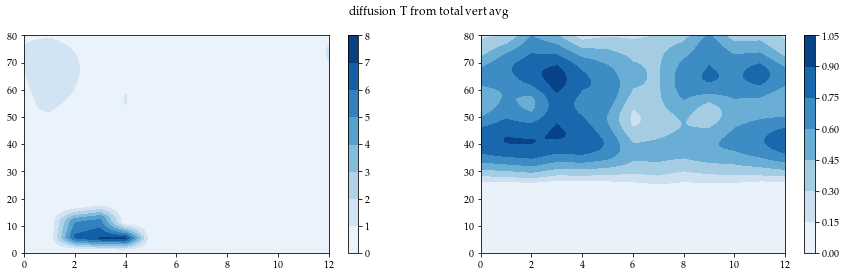

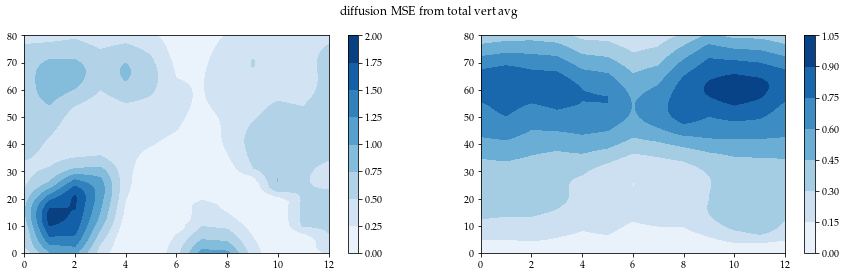

In [106]:

import numpy.ma as ma

level=1

def add_month(y):
    return np.append(y,y[...,0,None],axis=-1)

def save_from_zero_error(threshold,y):
    ind=(np.where((y<threshold) & (y>0)))
    y[ind]=threshold
    ind=(np.where((y>-1*threshold) & (y<0)))
    y[ind]=-1*threshold
    return y

def remove_negative(threshold,y):
    ind=(np.where((y<threshold)))
    y[ind]=threshold
    return y

def smooth_multi(y, box_pts,smoothing=1,ax=1):
    box = np.ones(box_pts)/box_pts
    y_smooth=np.apply_along_axis(np.convolve, ax, y, box, mode='same')
    if smoothing == 1 :
        return y_smooth
    else :
        return y
    
def vert_int1(y, pi=2, pf=-10):
    integral = (y*add_month(weights))[...,pi:pf,:].sum(axis=-2)
    average  = (y*add_month(weights))[...,pi:pf,:].mean(axis=-2)/(add_month(weights))[...,pi:pf,:].mean(axis=-2)
    return integral, average


Tv         = add_month(T)
divT       = spher_div_vert(Tv)
divMSE_all = spher_div_vert(add_month(Cp*T+g*Z+L*q))

import numpy.ma as ma

threshold               = 0.0001

dm_by_dphi              = vert_int1(divMSE_all)[1]
dm_by_dphi              = save_from_zero_error(0.004,dm_by_dphi)
dT_by_dphi              = vert_int1(divT)[1]
dT_by_dphi              = save_from_zero_error(0.000002,dT_by_dphi)

diffus_sfc_mse          = -add_month(TE+SE+MM)*10**15/(2*np.pi*a**3*np.cos(np.deg2rad(lat[None,:,None]))*dm_by_dphi)
diffus_sfc_mse          = remove_negative(0.00001,smooth_multi(diffus_sfc_mse,100))
diffus_sfc_T            = -add_month(TE_sens+SE_sens+MM_sens)*10**15/(2*np.pi*a**3*np.cos(np.deg2rad(lat[None,:,None]))*dT_by_dphi)
diffus_sfc_T            = remove_negative(0.0001,smooth_multi(diffus_sfc_T,100))

diffusion_data = {
    "lat"            : lat,
    "divT"           : divT,
    "T"              : Tv,
    "MSE"            : add_month(Cp*T+g*Z+L*q),
    "dm_by_dphi"     : dm_by_dphi,
    "dT_by_dphi"     : dT_by_dphi,
    "diffus_sfc_mse" : diffus_sfc_mse,
    "diffus_sfc_T"   : diffus_sfc_T,
    "heat_flux_PW"   : add_month(TE_sens+SE_sens+MM_sens),
    "heat_flux_Wm-1" : add_month(TE_sens+SE_sens+MM_sens)*10**15/(2*np.pi*a*np.cos(np.deg2rad(lat[None,:,None]))),  
    "MSE_flux_PW"    : add_month(TE+SE+MM),
    "MSE_flux_Wm-1"  : add_month(TE+SE+MM)*10**15/(2*np.pi*a*np.cos(np.deg2rad(lat[None,:,None]))),   
}

# make_sure_path_exists("/project2/tas1/pragallva/climlab/data/")
# save("/project2/tas1/pragallva/climlab/data/diffusion_data_from_total_vert_avg.hkl", diffusion_data)
py.figure(figsize=(15,4))
py.subplot(1,2,1)
py.ylim(0,80)
py.contourf(range(13), lat, diffus_sfc_T[0,...], cmap= cm.Blues ); py.colorbar()
py.subplot(1,2,2)
py.contourf(range(13), lat, diffus_sfc_T[1,...], cmap= cm.Blues ); py.colorbar()
py.ylim(0,80)
py.suptitle("diffusion T from total vert avg")

py.figure(figsize=(15,4))
py.subplot(1,2,1)
py.ylim(0,80)
py.contourf(range(13), lat, Cp*diffus_sfc_mse[0,...], cmap= cm.Blues ); py.colorbar()
py.subplot(1,2,2)
py.contourf(range(13), lat, Cp*diffus_sfc_mse[1,...], cmap= cm.Blues ); py.colorbar()
py.ylim(0,80)
py.suptitle("diffusion MSE from total vert avg")


# Check the correlation between diffusivity and EKE. 

#### Calculate EKE and D values at the storm track position

In [107]:
D_a=inerp_at_max(diffusivity_sfc,lat_a)
# D_ebm=diffus_sfc_mse*1000
# D_ebm_a  ,gZv_a, Lqv_a, MSEv_a, stream_int_a,  lat_a = N_S_avg(D_ebm, g*Z, L*q, Cp*T+g*Z+L*q,stream_int, lat, 1)
# D_a=inerp_at_max(D_ebm_a,lat_a)
eke_lev_a=[]

eke_a=inerp_at_max(np.sqrt(EKE_a),lat_a)
psi_a=inerp_at_max(stream_int_a,lat_a)
psi_850_a=inerp_at_max(stream_850_a,lat_a)

for l in range(len(sigma_full)):
    eke_lev_a.append(inerp_at_max(np.sqrt(EKEv_a[...,l,:]),lat_a))
eke_lev_a=np.array(eke_lev_a).transpose(1,0,2)

In [108]:
from scipy import stats
import numpy as np
def regress(d,y,X=D_a):
    x = X[d,:]
    y = y[d,:]
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    return slope, intercept, r_value, p_value, std_err

[610.42943318  72.24891176]
[0.224062   0.85050136]
[0.60956711 1.16945799]


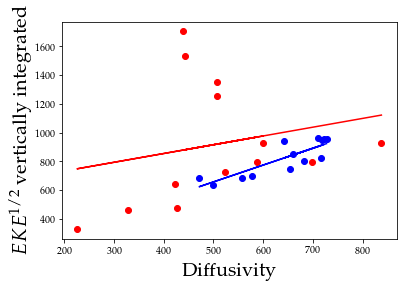

In [109]:
slope=np.ones(2); intercept=np.copy(slope); p_value=np.copy(slope); std_err=np.copy(slope); r_value=np.copy(slope);
for d in range(len(DEPTHS)):
    slope[d], intercept[d], r_value[d], p_value[d], std_err[d] = regress(d,eke_a)


c=['r','b']
for d in range(len(DEPTHS)):
    py.plot(D_a[d,:],eke_a[d,:],c[d]+'o')
    py.plot(D_a[d,:],slope[d]*D_a[d,:]+intercept[d],c[d]+'-')

print intercept
print r_value
print slope

py.ylabel(r"$EKE^{1/2}$ vertically integrated",fontsize=20)
py.xlabel("Diffusivity ",fontsize=20)

[ 806151.31818689 -509060.3637548 ]
[0.07188436 0.83354423]
[ 403.8971797  1868.97968516]


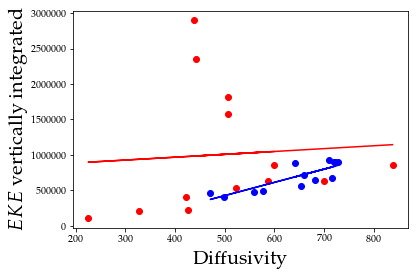

In [110]:
slope=np.ones(2); intercept=np.copy(slope); p_value=np.copy(slope); std_err=np.copy(slope); r_value=np.copy(slope);
for d in range(len(DEPTHS)):
    slope[d], intercept[d], r_value[d], p_value[d], std_err[d] = regress(d,eke_a**2)


c=['r','b']
for d in range(len(DEPTHS)):
    py.plot(D_a[d,:],eke_a[d,:]**2,c[d]+'o')
    py.plot(D_a[d,:],slope[d]*D_a[d,:]+intercept[d],c[d]+'-')

print intercept
print r_value
print slope

py.ylabel(r"$EKE$ vertically integrated",fontsize=20)
py.xlabel("Diffusivity ",fontsize=20)



[ 2.85670497e+08 -5.10403630e+06]
[-0.03425262  0.86407563]
[-24961.0913751  314737.73407569]


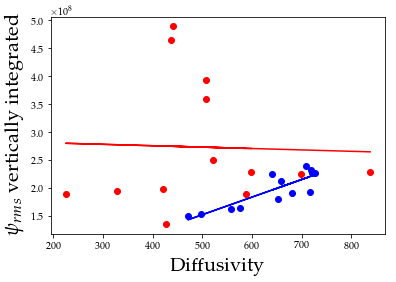

In [111]:
slope=np.ones(2); intercept=np.copy(slope); p_value=np.copy(slope); std_err=np.copy(slope); r_value=np.copy(slope);
for d in range(len(DEPTHS)):
    slope[d], intercept[d], r_value[d], p_value[d], std_err[d] = regress(d,psi_a)


c=['r','b']
for d in range(len(DEPTHS)):
    py.plot(D_a[d,:],psi_a[d,:],c[d]+'o')
    py.plot(D_a[d,:],slope[d]*D_a[d,:]+intercept[d],c[d]+'-')
    
py.ylabel(r"$\psi_{rms} $ vertically integrated",fontsize=20)
py.xlabel("Diffusivity ",fontsize=20)

print intercept
print r_value
print slope

In [112]:
10**15/(244202.67*2*np.pi*R)

102.29681649248445

In [113]:
10**15/(246830.92*2*np.pi*R)

101.20756232632742

[6441991.02986458 1737030.808411  ]
[0.18146344 0.82943601]
[4264.27413738 8950.81455248]


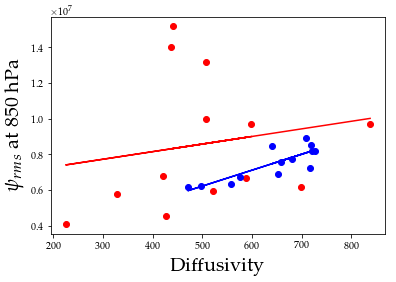

In [114]:
slope=np.ones(2); intercept=np.copy(slope); p_value=np.copy(slope); std_err=np.copy(slope); r_value=np.copy(slope);
for d in range(len(DEPTHS)):
    slope[d], intercept[d], r_value[d], p_value[d], std_err[d] = regress(d,psi_850_a)


c=['r','b']
for d in range(len(DEPTHS)):
    py.plot(D_a[d,:],psi_850_a[d,:],c[d]+'o')
    py.plot(D_a[d,:],slope[d]*D_a[d,:]+intercept[d],c[d]+'-')
    
py.ylabel(r"$\psi_{rms} $ at 850 hPa",fontsize=20)
py.xlabel("Diffusivity ",fontsize=20)

print intercept
print r_value
print slope

In [115]:
10**15/(8541.98*2*np.pi*R*10000)

0.29245158288786366

In [116]:
10**15/(7136.65*2*np.pi*R*10000)

0.35004036515682757

[ 42016812.1221571  -18014216.40249002]
[0.94057938 0.98594968]
[251948.58898554 261181.37233937]


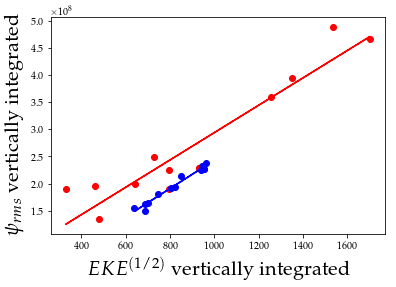

In [117]:
slope=np.ones(2); intercept=np.copy(slope); p_value=np.copy(slope); std_err=np.copy(slope); r_value=np.copy(slope);
for d in range(len(DEPTHS)):
    slope[d], intercept[d], r_value[d], p_value[d], std_err[d] = regress(d,psi_a, eke_a)


c=['r','b']
for d in range(len(DEPTHS)):
    py.plot(eke_a[d,:],psi_a[d,:],c[d]+'o')
    py.plot(eke_a[d,:],slope[d]*eke_a[d,:]+intercept[d],c[d]+'-')
    
py.xlabel(r"$EKE^{(1/2)} $ vertically integrated",fontsize=20)
py.ylabel(r"$\psi_{rms} $ vertically integrated",fontsize=20)

print intercept
print r_value
print slope

[2.53812428 0.9689823 ]
[0.4970118 0.8944252]
[0.00702339 0.00783575]


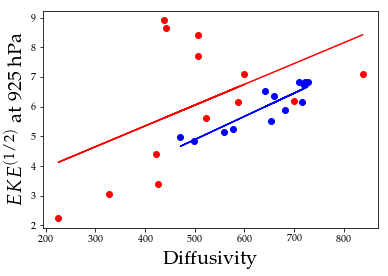

In [118]:
lev=1
slope=np.ones(2); intercept=np.copy(slope); p_value=np.copy(slope); std_err=np.copy(slope); r_value=np.copy(slope);
for d in range(len(DEPTHS)):
    slope[d], intercept[d], r_value[d], p_value[d], std_err[d] = regress(d,eke_lev_a[:,lev,:])

c=['r','b']
for d in range(len(DEPTHS)):
    py.plot(D_a[d,:],eke_lev_a[d,lev,:],c[d]+'o')
    py.plot(D_a[d,:],slope[d]*D_a[d,:]+intercept[d],c[d]+'-')
py.ylabel(r"$EKE^{(1/2)} $ at 925 hPa",fontsize=20)
py.xlabel("Diffusivity ",fontsize=20)


print intercept
print r_value
print slope

[ 10.22315562 -22.02858254]
[0.38247547 0.88212674]
[0.06197969 0.09122673]


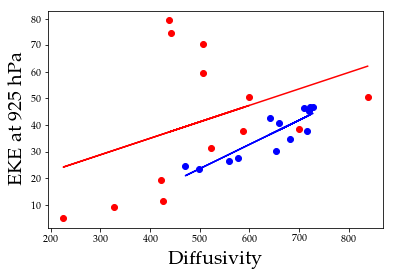

In [119]:
lev=1
slope=np.ones(2); intercept=np.copy(slope); p_value=np.copy(slope); std_err=np.copy(slope); r_value=np.copy(slope);
for d in range(len(DEPTHS)):
    slope[d], intercept[d], r_value[d], p_value[d], std_err[d] = regress(d,eke_lev_a[:,lev,:]**2)

c=['r','b']
for d in range(len(DEPTHS)):
    py.plot(D_a[d,:],eke_lev_a[d,lev,:]**2,c[d]+'o')
    py.plot(D_a[d,:],slope[d]*D_a[d,:]+intercept[d],c[d]+'-')
py.ylabel("EKE  at 925 hPa     ",fontsize=20)
py.xlabel("Diffusivity ",fontsize=20)

print intercept
print r_value
print slope

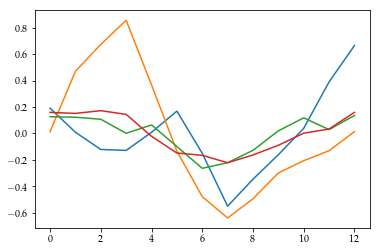

In [120]:
d=0
py.plot((D_a[d,:]-D_a[d,:].mean())/D_a[d,:].mean())
py.plot( (eke_a[d,:]-eke_a[d,:].mean())/eke_a[d,:].mean()  ) 

d=1
py.plot((D_a[d,:]-D_a[d,:].mean())/D_a[d,:].mean())
py.plot( (eke_a[d,:]-eke_a[d,:].mean())/eke_a[d,:].mean()  ) 

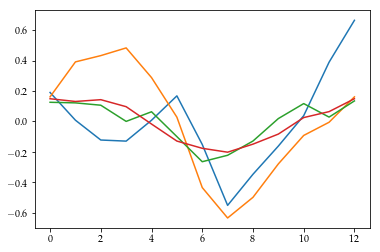

In [121]:
lev=2

d=0
py.plot((D_a[d,:]-D_a[d,:].mean())/D_a[d,:].mean())
py.plot( (eke_lev_a[d,lev,:]-eke_lev_a[d,lev,:].mean())/eke_lev_a[d,lev,:].mean()  ) 

d=1
py.plot((D_a[d,:]-D_a[d,:].mean())/D_a[d,:].mean())
py.plot( (eke_lev_a[d,lev,:]-eke_lev_a[d,lev,:].mean())/eke_lev_a[d,lev,:].mean()  ) 

## For shift decomposition

In [122]:
level=level

threshold=0.001
high =10**10

mask_of_TE_a            = ma.masked_less(TE_a, threshold)  ### Positive transient eddies
mask_of_div_MSE_a       = ma.masked_greater(div_MSE[...,level,:], -1*threshold) ### Negative MSE gradient
masked_div_MSE_a        = ma.masked_where( ma.getmask(mask_of_div_MSE_a) , div_MSE[...,level,:])
masked_TE_a             = ma.masked_where( ma.getmask(mask_of_TE_a), TE_a)

def mask_of_extreme_high_low(y,high):
    sh   = ma.masked_greater(y, high)
    sl   = ma.masked_less(y, -1*high)  
    maskh= ma.getmask(sh)
    maskl= ma.getmask(sl)
    masked_s = ma.masked_where( maskh, y)
    masked_s = ma.masked_where( maskl, masked_s)
    return masked_s


def smooth_multi(y, box_pts,smoothing=1,ax=1):
    box = np.ones(box_pts)/box_pts
    y_smooth=np.apply_along_axis(np.convolve, ax, y, box, mode='same')
    if smoothing == 1 :
        return y_smooth
    else :
        return y
    

dm_by_dphi      =  masked_div_MSE_a
diffusivity_sfc = -masked_TE_a/dm_by_dphi


dm2_by_dphi2              = spher_div(div_MSE[...,level,:])*10**15
dm2_by_dphi2              = ma.masked_where( ma.getmask(mask_of_div_MSE_a), dm2_by_dphi2)
dm2_by_dphi2              = ma.masked_where( ma.getmask(mask_of_TE_a), dm2_by_dphi2)

div_diffusivity_sfc       = spher_div(diffusivity_sfc)*10**15
div_diffusivity_sfc       = ma.masked_where( ma.getmask(mask_of_TE_a), div_diffusivity_sfc)
div_diffusivity_sfc       = ma.masked_where( ma.getmask(mask_of_div_MSE_a), div_diffusivity_sfc)
div_diffusivity_sfc       = mask_of_extreme_high_low(div_diffusivity_sfc,high=10**9)

Im_dD_by_dphi             = -1*dm_by_dphi*div_diffusivity_sfc
D_dIm_by_dphi             = -1*diffusivity_sfc*dm2_by_dphi2

N=1
d1  =   smooth_multi(-1*mean(div_diffusivity_sfc)*prime(dm_by_dphi),N,-1) 
d2  =   smooth_multi(-1*prime(div_diffusivity_sfc)*mean(dm_by_dphi),N,1)
d3  =   smooth_multi(-1*prime(div_diffusivity_sfc)*prime(dm_by_dphi),N,1) 

d4  =   smooth_multi(-1*mean(diffusivity_sfc)*prime(dm2_by_dphi2),N,1)
d5  =   smooth_multi(-1*prime(diffusivity_sfc)*mean(dm2_by_dphi2),N,1)
d6  =   smooth_multi(-1*prime(diffusivity_sfc)*prime(dm2_by_dphi2),N,1)

d3m =   smooth_multi(-1*np.asarray( [np.squeeze(mean(d3))]*13).transpose(1,2,0),N)
d4m =   smooth_multi(-1*np.asarray( [np.squeeze(mean(d4))]*13).transpose(1,2,0),N)

F   =    mean(div_TE_a)

In [123]:
import numpy as np
def calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=1):
    
    div_TE_a=spher_div(TE_a*10**15)
    
    te=div_TE_a
    
    def diff(x):
        return x[:,:,1:]-x[:,:,:-1] 
    base_pos=te[...,:-1]
    
    if month_to_month==0 :
      def diff(x):
         return x[:,:,1:]-x[...,1:,None].mean(axis=2)    
      base_pos=te[...,1:,None].mean(axis=2)
    
    TE_change=base_pos+diff(div_TE_a)
    d1_change=base_pos+diff(d1)
    d2_change=base_pos+diff(d2)
    d3_change=base_pos+diff(d3)
    d4_change=base_pos+diff(d4)
    d5_change=base_pos+diff(d5)
    d6_change=base_pos+diff(d6)
    
    a = lambda x: np.append(x[:,:,-1,None],x,axis=-1)
    
    return a(TE_change), a(d1_change), a(d2_change), a(d3_change), a(d4_change), a(d5_change), a(d6_change)

d_changes = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month=0)

In [124]:
def find_zero(div,i,zero=0):
  depths=div.shape[0];
  months=div.shape[-1];
  zero_loc = np.zeros((depths,months))
  for d in range(0,depths):
      for m in range(0,months):
            if ((d==0) & ((m==6) | (m==7) | (m==8)) & (i==2)) :
               #print d, m 
               l_range=((lat_a>=45) & (lat_a<=60))
            else:
                l_range=((lat_a>=33) & (lat_a<=60))
            interpolation_function = interp1d(div[d,l_range,m],lat_a[l_range],kind='linear')
            try :
                zero_loc[d,m]=interpolation_function(zero)
            except ValueError as err:
                zero_loc[d,m]=np.nan        
  return zero_loc

In [125]:
def threshold(I,value, position):
      for d in range(len(DEPTHS)):  
        for m in range(13):
            if (np.abs(I[d,m])<value) :
                for l in range(np.shape(position)[0]):
                   position[l][d,m]=np.nan
      return position

positions = threshold(Intensity_te, 0.0, [find_zero(d_changes[i],i) for i in range(7)])
positions[0]= find_zero(d_changes[0],0,zero=-0.0)

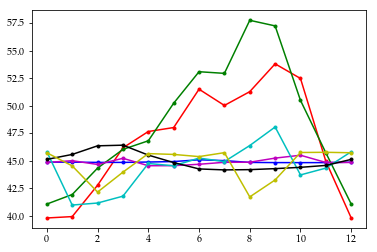

In [126]:
d=0
py.plot(positions[0][d,:],'r.-')
py.plot(positions[1][d,:],'b.-')
py.plot(positions[2][d,:],'g.-')
py.plot(positions[3][d,:],'m.-')
py.plot(positions[4][d,:],'c.-')
py.plot(positions[5][d,:],'k.-')
py.plot(positions[6][d,:],'y.-')

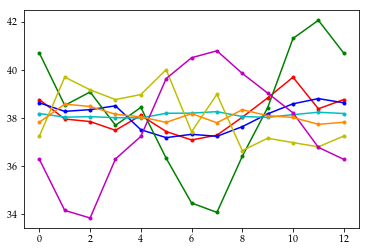

In [127]:
d=1
py.plot(positions[0][d,:],'r.-')
py.plot(positions[1][d,:],'b.-')
py.plot(positions[2][d,:],'g.-')
py.plot(positions[3][d,:],'c.-')
py.plot(positions[4][d,:],'y.-')
py.plot(positions[5][d,:],'m.-')
py.plot(positions[6][d,:],'.-',c='#ff8a00ff')

In [128]:
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

def plot_monthly_shift(d,l,month_to_month=0,threshold_value=0.0) :
        
    DEPTHS_title=["5m", "50m"]
    I=Intensity_te    
    n=d+1    
    d_changes = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month)
    positions = threshold(Intensity_te, 0.0, [find_zero(d_changes[i],i) for i in range(7)])   
    m=range(0,13)

    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    zero_div_TE=positions[0]
    TE_change=d_changes[0]
    base_pos=zero_div_TE[d,:-1]
    def add_month_to_end(y1) :
        y=np.append(y1[-1],y1)
        return y
        
    if month_to_month==0:
        s=TE_change[d,:,1:].mean(axis=-1)[None,:,None]
        base_pos=np.squeeze(find_zero(s,0))
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        #base_pos=44 #np.nanmean(zero_div_TE[d,:-1])
        print base_pos
        
    TE_obs_pos         = add_month_to_end(zero_div_TE[d,1:]-base_pos)
    d1_pos             = add_month_to_end(positions[1][d,1:]-base_pos)
    d2_pos             = add_month_to_end(positions[2][d,1:]-base_pos)
    d3_pos             = add_month_to_end(positions[3][d,1:]-base_pos)
    d4_pos             = add_month_to_end(positions[4][d,1:]-base_pos)
    d5_pos             = add_month_to_end(positions[5][d,1:]-base_pos)
    d6_pos             = add_month_to_end(positions[6][d,1:]-base_pos)
    TE_calc_pos        = d1_pos+d2_pos+d3_pos+d4_pos+d5_pos+d6_pos
    nonlinear_error    = TE_obs_pos-TE_calc_pos        
#     py.subplot(220+n)
#     py.subplot(2,4,n)
    fig=py.plot(TE_obs_pos,'r.-',label=r'$\Delta\phi$',linewidth=3.5,markersize=20)
    fig=py.plot(d1_pos,'b.-',label=r'$\Delta\phi_{{{1}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(d2_pos,'g.-',label=r'$\Delta\phi_{{{2}}}$',linewidth=3.5,markersize=20)
    fig=py.plot(d3_pos,'c.-',label=r'$\Delta\phi_{{{3}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(d4_pos,'y.-',label=r'$\Delta\phi_{{{4}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(d5_pos,'m.-',label=r'$\Delta\phi_{{{5}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(d6_pos,'.-',c='#ff8a00ff',label=r'$\Delta\phi_{{{6}}}$',linewidth=2.0,markersize=20)
    fig=py.plot(nonlinear_error,'k.-',label=r'${nonlinear}$',linewidth=2.0,markersize=20)
#     print TE_obs_pos.shape
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,+1*l)
    py.ylabel("deg \\ poleward", fontsize=25)

    title="shift decomposition"+" "+" ("+str(depth)+"m)"
    title1="shift_decomp"+"_"+str(depth)+"m"
    py.title(str(DEPTHS_title[d]),fontsize=30,y=1.03)
    #py.title(title, fontsize=35)
    py.xticks(m, mticks,size=15)
    py.tick_params(labelsize=20,size=4,width=2)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    if d==1:
        py.legend(loc='best',fontsize=20,ncol=3,frameon=False)
    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
   
    

In [129]:
py.rc('text', usetex=True)
py.rc('font', family='serif', serif='Palatino',weight='bold')

def plot_monthly_shift(d,l,month_to_month=0,threshold_value=0.0) :
        
    DEPTHS_title=["5m", "50m"]
    I=Intensity_te    
    n=d+1    
    d_changes = calculate_shift_just_by_adding_individual_flux_divergences(month_to_month)
    positions = threshold(Intensity_te, threshold_value, [find_zero(d_changes[i],i) for i in range(7)])  
#     positions[0]= find_zero(d_changes[0],0,zero=-1.0)
    m=range(0,13)

    mticks = ['J-D','F-J','M-F','A-M','M-A','J-M','J-J','A-J','S-A','O-S','N-O','D-N','J-D']
    
    zero_div_TE=positions[0]
    TE_change=d_changes[0]
    base_pos=zero_div_TE[d,:-1]
    def add_month_to_end(y1) :
        y=np.append(y1[-1],y1)
        return y
        
    if month_to_month==0:
        s=TE_change[d,:,1:].mean(axis=-1)[None,:,None]
        base_pos=np.squeeze(find_zero(s,0))
        mticks = ['J','F','M','A','M','J','J','A','S','O','N','D','J']
        #base_pos=44 #np.nanmean(zero_div_TE[d,:-1])
        print base_pos
        
    TE_obs_pos         = add_month_to_end(zero_div_TE[d,1:]-base_pos)
    d1_pos             = add_month_to_end(positions[1][d,1:]-base_pos)
    d2_pos             = add_month_to_end(positions[2][d,1:]-base_pos)
    d3_pos             = add_month_to_end(positions[3][d,1:]-base_pos)
    d4_pos             = add_month_to_end(positions[4][d,1:]-base_pos)
    d5_pos             = add_month_to_end(positions[5][d,1:]-base_pos)
    d6_pos             = add_month_to_end(positions[6][d,1:]-base_pos)
    TE_calc_pos        = d1_pos+d2_pos+d3_pos+d4_pos+d5_pos+d6_pos
    nonlinear_error    = TE_obs_pos-TE_calc_pos        
#     py.subplot(220+n)
#     py.subplot(2,4,n)

    D1=d1_pos+d4_pos
    D2=d2_pos+d5_pos
    
    fig=py.plot(TE_obs_pos,'r.-',label=r'$\Delta\phi$',linewidth=3.5,markersize=10)
    fig=py.plot(D1,'b.-',label=r'$\Delta\phi_{{{1}}}$',linewidth=2.0,markersize=10)
    fig=py.plot(D2,'k.-',label=r'$\Delta\phi_{{{2}}}$',linewidth=3.5,markersize=10)
#     print TE_obs_pos.shape
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,+1*l)
    py.ylabel("deg \\ poleward", fontsize=40)

    title="shift decomposition"+" "+" ("+str(depth)+"m)"
    title1="shift_decomp"+"_"+str(depth)+"m"
    py.tick_params(labelsize=20,size=4,width=2)
    py.axhspan(-1.0, 1.0, facecolor='0.5', alpha=0.3)
    py.tight_layout()
    if d==1:
        py.legend(loc='best',fontsize=20,ncol=3,frameon=False)
        
        
        
    py.axhline(0, color='k',linewidth=1.5)
    py.xlim(0,12)
    py.ylim(-1*l,l)
    title=""+" "+" "+str(depth)+"m"
    py.title(str(DEPTHS_title[d]),fontsize=35,y=1.03)
    py.xticks(range(13), mticks,size=37)
    py.tick_params(labelsize=30,size=5,width=1)

    py.subplots_adjust(left=0.12, right=0.88, top=0.88, bottom=0.10, wspace=0.15, hspace=0.3)
   
    

$\begin{alignat}{1}
\Delta F= & \underset{d_{1}}{\underbrace{-\partial_{y}D_{o}\Delta(I_{m})}}\ \ \ \underset{d_{2}}{\underbrace{-\Delta\left(\partial_{y}D\right)I_{m_{o}}}}\ \ \ \underset{d_{3}}{\underbrace{-\Delta\left(\partial_{y}D\right)\Delta(I_{m})}}\nonumber \\
 & \underset{d_{4}}{\underbrace{-D_{o}\Delta(\partial_{y}I_{m})}}\underset{d_{5}}{\ \underbrace{\ \ -\Delta\left(D\right)\partial_{y}I_{m_{o}}}\ \ \ }\underset{d_{6}}{\underbrace{-\Delta\left(D\right)\Delta(\partial_{y}I_{m})}}
\end{alignat}$

$\begin{equation}
\Delta\phi=\Delta\phi_{1}+\Delta\phi_{2}+\Delta\phi_{3}+\Delta\phi_{4}+\Delta\phi_{5}+\Delta\phi_{6}+\Delta\phi_{CT}
\end{equation}$



44.88224326558654


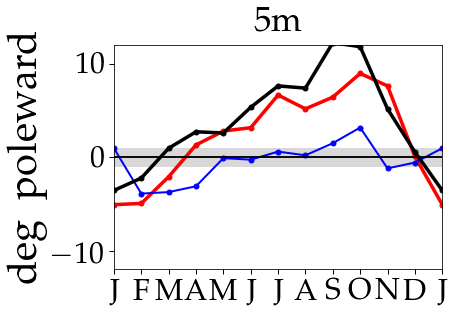

In [130]:
plot_monthly_shift(0,12,month_to_month=0,threshold_value=0.0)